In [1]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryF1Score, MultilabelF1Score,MultilabelAUROC, MultilabelPrecision, MultilabelRecall, BinaryAUROC

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

import torch.nn as nn

import numpy as np
import pickle

In [3]:
smiles_test = pd.read_csv("Data_set/Test/test.csv").set_index("CID")["IsomericSMILES"]

Utility function to load data in.

In [6]:
def load_train_data_original():
    train_data = pd.read_csv("Data_set/Train/train.csv")
    train_data.set_index("CID", inplace=True)

    labels = pd.read_csv("Data_set/all_compounds.csv")
    labels = labels.set_index("CID")
    train_data = labels.loc[train_data.index]

    features = pd.read_csv("Data_set/mordred_features-final_selection-imputed.csv")
    features.set_index("CID", inplace=True)

    X = features.reindex(index=train_data.index)
    y = train_data.iloc[:,3:]

    #Drop all rows in y that are all 0's (no classes)
    to_be_dropped = y.loc[~(y==0).all(axis=1)].index
    y = y.loc[to_be_dropped]
    X = X.loc[to_be_dropped]

    return X, y

def load_test_data_original():
    test_data = pd.read_csv("Data_set/Test/test.csv")
    test_data.set_index("CID", inplace=True)

    labels = pd.read_csv("Data_set/all_compounds.csv")
    labels = labels.set_index("CID")
    test_data = labels.loc[test_data.index]

    features = pd.read_csv("Data_set/mordred_features-final_selection-imputed.csv")
    features.set_index("CID", inplace=True)

    y = test_data.iloc[:,3:]
    X = features.reindex(index=test_data.index)

    #Drop all rows in y that are all 0's (no classes)
    to_be_dropped = y.loc[~(y==0).all(axis=1)].index
    y = y.loc[to_be_dropped]
    X = X.loc[to_be_dropped]

    return X, y

def load_train_data():
    train_data = pd.read_csv("Data_set/Train/train.csv")
    train_data.set_index("CID", inplace=True)

    # #Drop majority classes
    # train_data = train_data.drop(columns=['woody'])
    # train_data = train_data.drop(columns=['spices'])
    # train_data = train_data.drop(columns=['earthy'])
    # train_data = train_data.drop(columns=['aquatic'])
    # train_data = train_data.drop(columns=['alcohol'])
    # train_data = train_data.drop(columns=['animal'])


    features = pd.read_csv("Data_set/mordred_features-final_selection-imputed.csv")
    features.set_index("CID", inplace=True)

    X = features.reindex(index=train_data.index)
    y = train_data.iloc[:, -11:]

    #Drop all rows in y that are all 0's (no classes)
    to_be_dropped = y.loc[~(y==0).all(axis=1)].index
    y = y.loc[to_be_dropped]
    X = X.loc[to_be_dropped]

    return X, y

def load_test_data():
    test_data = pd.read_csv("Data_set/Test/test.csv")
    test_data.set_index("CID", inplace=True)

    #Drop majority classes
    # test_data = test_data.drop(columns=['woody'])
    # test_data = test_data.drop(columns=['spices'])
    # test_data = test_data.drop(columns=['earthy'])
    # test_data = test_data.drop(columns=['aquatic'])
    # test_data = test_data.drop(columns=['alcohol'])
    # test_data = test_data.drop(columns=['animal'])

    features = pd.read_csv("Data_set/mordred_features-final_selection-imputed.csv")
    features.set_index("CID", inplace=True)

    y = test_data.iloc[:, -11:]
    X = features.reindex(index=test_data.index)

    #Drop all rows in y that are all 0's (no classes)
    to_be_dropped = y.loc[~(y==0).all(axis=1)].index
    y = y.loc[to_be_dropped]
    X = X.loc[to_be_dropped]

    return X, y

TRAIN SHAPE:  (4182, 78) (4182, 11)
VALID SHAPE:  (1046, 78) (1046, 11)
TEST SHAPE:  (1314, 78) (1314, 11)


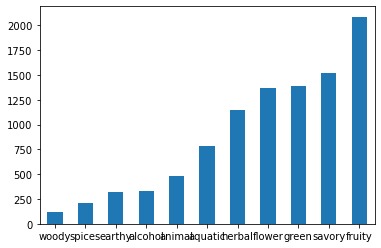

In [7]:
X_train, y_train = load_train_data()

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_test, y_test = load_test_data()

print("TRAIN SHAPE: ", X_train.shape, y_train.shape)
print("VALID SHAPE: ", X_valid.shape, y_valid.shape)
print("TEST SHAPE: ", X_test.shape, y_test.shape)

#Plot bins of value counts in y_train
import matplotlib.pyplot as plt
y_train.sum(axis=0).sort_values().plot.bar(rot=0)
plt.show()

In [8]:
def get_test_metrics_tabnet(clf, X, y, num_labels):
    results_per_class = pd.DataFrame(columns=["AUROC", "F1", "Precision", "Recall"], index=y.columns)
    results_per_class = results_per_class.fillna(0)

    y_hat = np.vstack(clf.predict(X.values)).T.astype(int)

    auroc_per_class = pd.Series(MultilabelAUROC(num_labels=num_labels, average=None)(torch.tensor(y_hat, dtype=torch.float), torch.tensor(y.values, dtype=torch.long)).numpy(), index=y.columns)
    f1_per_class = pd.Series(MultilabelF1Score(num_labels=num_labels, average=None)(torch.tensor(y_hat, dtype=torch.float), torch.tensor(y.values, dtype=torch.float)).numpy(), index=y.columns)
    precision_per_class = pd.Series(MultilabelPrecision(num_labels=num_labels, average=None)(torch.tensor(y_hat, dtype=torch.float), torch.tensor(y.values, dtype=torch.float)).numpy(), index=y.columns)
    recall_per_class = pd.Series(MultilabelRecall(num_labels=num_labels, average=None)(torch.tensor(y_hat, dtype=torch.float), torch.tensor(y.values, dtype=torch.float)).numpy(), index=y.columns)

    df = pd.DataFrame({"AUROC": auroc_per_class, "F1": f1_per_class, "Precision": precision_per_class, "Recall": recall_per_class})
    results_per_class = results_per_class.add(df, fill_value=0)

    results_per_class.loc["Average"] = results_per_class.mean()

    return results_per_class, y_hat

def get_test_metrics_rf(clf, X, y, num_labels):
    results_per_class = pd.DataFrame(columns=["AUROC", "F1", "Precision", "Recall"], index=y.columns)
    results_per_class = results_per_class.fillna(0)

    y_hat = clf.predict(X)

    auroc_per_class = pd.Series(MultilabelAUROC(num_labels=num_labels, average=None)(torch.tensor(y_hat, dtype=torch.float), torch.tensor(y.values, dtype=torch.long)).numpy(), index=y.columns)
    f1_per_class = pd.Series(MultilabelF1Score(num_labels=num_labels, average=None)(torch.tensor(y_hat, dtype=torch.float), torch.tensor(y.values, dtype=torch.float)).numpy(), index=y.columns)
    precision_per_class = pd.Series(MultilabelPrecision(num_labels=num_labels, average=None)(torch.tensor(y_hat, dtype=torch.float), torch.tensor(y.values, dtype=torch.float)).numpy(), index=y.columns)
    recall_per_class = pd.Series(MultilabelRecall(num_labels=num_labels, average=None)(torch.tensor(y_hat, dtype=torch.float), torch.tensor(y.values, dtype=torch.float)).numpy(), index=y.columns)

    df = pd.DataFrame({"AUROC": auroc_per_class, "F1": f1_per_class, "Precision": precision_per_class, "Recall": recall_per_class})
    results_per_class = results_per_class.add(df, fill_value=0)

    results_per_class.loc["Average"] = results_per_class.mean()

    return results_per_class, y_hat

In [9]:
from pytorch_tabnet.metrics import Metric

from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

class AUC_ROC(Metric):
    def __init__(self):
        self._name = "auc_roc_macro"
        self._maximize = True

    def __call__(self, y_true, y_score):
        try:
            auc = roc_auc_score(y_true, y_score[:,1], average='macro')
        except:
            auc = 0
            
        return auc


In [11]:
from pytorch_tabnet.multitask import TabNetMultiTaskClassifier
from sklearn.preprocessing import StandardScaler

file = open("Data_set/Models/FinalModels/pickled_tabnet.pkl", "rb")

clf = pickle.load(file)
file.close()

# clf = TabNetMultiTaskClassifier(
#         optimizer_fn=torch.optim.Adam,
#         optimizer_params=dict(lr=0.007259125069500482),
#         lambda_sparse=3.4659020464785074e-05,
#         mask_type='entmax',
#         momentum=0.04783687227392281,
#         n_a=64,
#         n_d=64,
#         n_independent=4,
#         n_shared=1,
#         n_steps=3,
#         scheduler_params = {"gamma": 0.95,
#                      "step_size": 20},
#         scheduler_fn=torch.optim.lr_scheduler.StepLR
#         )

# clf.fit(
#     X_train.values, y_train.values,
#     eval_set=[(X_valid.values, y_valid.values)],
#     max_epochs=800,
#     patience=80,
#     eval_metric=[AUC_ROC],
#     loss_fn=torch.nn.CrossEntropyLoss()
# )


In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from xgboost import XGBClassifier

results_per_class_tabnet = get_test_metrics_tabnet(clf, X_test, y_test,num_labels = y_train.shape[1])

print("TABNET:\n", results_per_class_tabnet[0].style.to_latex())

file = open("Data_set/Models/FinalModels/pickled_rf.pkl", "rb")

rf = pickle.load(file)
file.close()

# rf = MultiOutputClassifier(RandomForestClassifier(random_state=0))
# rf.fit(X_train, y_train)

#file = open("Data_set/Models/FinalModels/pickled_xgboost.pkl", "rb")

# xgboost = pickle.load(file)
# file.close()
xgboost = XGBClassifier(learning_rate=0.1,
                                    n_estimators=3500,
                                    max_depth=10,
                                    min_child_weight=5,
                                    subsample=0.9,
                                    colsample_bytree=0.85,
                                    gamma=0.3,
                                    objective= 'binary:logistic',
                                    scale_pos_weight=1,
                                    reg_alpha= 0.95,
                                    seed=27)
xgboost.fit(X_train, y_train)

results_per_class_xgboost = get_test_metrics_rf(xgboost, X_test, y_test, num_labels = y_test.shape[1])

results_per_class_rf = get_test_metrics_rf(rf, X_test, y_test, num_labels = y_test.shape[1])

print("RF:\n", results_per_class_rf[0])
print("XGBOOST:\n", results_per_class_xgboost[0].style.to_latex())

# print("RF:\n",results_per_class_rf)
# print("XGBOOST:\n",results_per_class_xgboost)

results_per_class_tabnet[0].to_excel("../Results/results_per_class_tabnet.xlsx")
results_per_class_rf[0].to_excel("../Results/results_per_class_rf.xlsx")
results_per_class_xgboost[0].to_excel("../Results/results_per_class_xgboost.xlsx")

TABNET:
 \begin{tabular}{lrrrr}
 & AUROC & F1 & Precision & Recall \\
alcohol & 0.665696 & 0.418079 & 0.493333 & 0.362745 \\
animal & 0.640344 & 0.388186 & 0.489362 & 0.321678 \\
aquatic & 0.618389 & 0.381862 & 0.470588 & 0.321285 \\
earthy & 0.565201 & 0.203390 & 0.236842 & 0.178218 \\
flower & 0.723988 & 0.623899 & 0.663102 & 0.589074 \\
fruity & 0.728005 & 0.736765 & 0.705634 & 0.770769 \\
green & 0.675280 & 0.572939 & 0.529297 & 0.624424 \\
herbal & 0.653808 & 0.497175 & 0.508671 & 0.486188 \\
savory & 0.753224 & 0.684989 & 0.689362 & 0.680672 \\
spices & 0.595980 & 0.276596 & 0.419355 & 0.206349 \\
woody & 0.641601 & 0.333333 & 0.379310 & 0.297297 \\
Average & 0.660138 & 0.465201 & 0.507714 & 0.439882 \\
\end{tabular}



KeyboardInterrupt: 

In [9]:
file = open("Data_set/Models/FinalModels/pickled_rf_original.pkl", "rb")

rf_original = pickle.load(file)#MultiOutputClassifier(RandomForestClassifier(random_state=0))
file.close()#rf_original.fit(X_train_original, y_train_original)

file = open("Data_set/Models/FinalModels/pickled_xgboost_original.pkl", "rb")

xgboost_original = pickle.load(file)#XGBClassifier(random_state=0)
file.close()#xgboost_original.fit(X_train_original, y_train_original)

In [11]:
results_per_class_tabnet_original, y_hat_tabnet = get_test_metrics_tabnet(tabnet_original, X_test_original, y_test_original,num_labels = y_train_original.shape[1])
results_per_class_rf_original, y_hat_rf = get_test_metrics_rf(rf_original, X_test_original, y_test_original, num_labels = y_test_original.shape[1])
results_per_class_xgboost, y_hat_xgboost = get_test_metrics_rf(xgboost_original, X_test_original, y_test_original, num_labels = y_test_original.shape[1])

print('RF:\n', results_per_class_rf_original)
print("TABNET:\n", results_per_class_tabnet_original)
#print("RF:\n",results_per_class_rf_original)
print("XGBOOST:\n",results_per_class_xgboost)

results_per_class_tabnet_original.to_excel("../Results/results_per_class_tabnet_original.xlsx")
results_per_class_rf_original.to_excel("../Results/results_per_class_rf_original.xlsx")
results_per_class_xgboost.to_excel("../Results/results_per_class_xgboost.xlsx")
    

NameError: name 'tabnet_original' is not defined

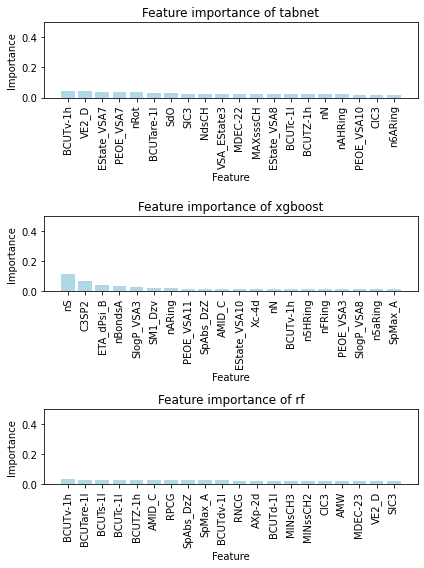

In [10]:
#Plot feature importance of clf
importances_tabnet = clf.feature_importances_
indices_tabnet = np.argsort(importances_tabnet)[::-1]
indices_tabnet = indices_tabnet[:20]
#Bar plot of feature importances
fig, axes = plt.subplots(3, 1, figsize=(6, 8))
axes[0].bar(range(20), importances_tabnet[indices_tabnet],
        color="lightblue", align="center")
axes[0].set_title("Feature importance of tabnet")
axes[0].set_xticks(range(20), X_train.columns[indices_tabnet], rotation=90)
axes[0].set_xlabel("Feature")
axes[0].set_ylabel("Importance")
axes[0].set_ylim(0, 0.5)

#Plot feature importance of xgboost
importances_xgboost = xgboost.feature_importances_
indices_xgboost = np.argsort(importances_xgboost)[::-1]
indices_xgboost = indices_xgboost[:20]
#Bar plot of feature importances
axes[1].bar(range(20), importances_xgboost[indices_xgboost],
        color="lightblue", align="center")
axes[1].set_title("Feature importance of xgboost")
axes[1].set_xticks(range(20), X_train.columns[indices_xgboost], rotation=90)
axes[1].set_xlabel("Feature")
axes[1].set_ylabel("Importance")
axes[1].set_ylim(0, 0.5)

#Plot feature importance of rf
#Get the average feature importance across all classifiers in 'rf'
feature_importances_rf = np.mean([tree.feature_importances_ for tree in rf.estimators_], axis=0)
importances_rf = feature_importances_rf
indices_rf = np.argsort(importances_rf)[::-1]
indices_rf = indices_rf[:20]

#Bar plot of feature importances
axes[2].bar(range(20), importances_rf[indices_rf],
        color="lightblue", align="center")
axes[2].set_title("Feature importance of rf")
axes[2].set_xticks(range(20), X_train.columns[indices_rf], rotation=90)
axes[2].set_xlabel("Feature")
axes[2].set_ylabel("Importance")
axes[2].set_ylim(0, 0.5)

plt.tight_layout()
plt.savefig("../images/FinalModels/feature_importances.png", dpi=300)

plt.show()

In [118]:
#Get the class proportions at each value for "nS"
nS = X_test["nS"].values
nS = np.round(nS, 2)
nS = np.unique(nS)

class_proportions_ns = pd.DataFrame(columns=y_test.columns, index=nS)

for i in nS:
    class_proportions_ns.loc[i] = y_test.loc[X_test.index[X_test["nS"] == i]].sum(axis=0)/len(y_test.loc[X_test.index[X_test["nS"] == i]])

#Get the class proportions at each value for "BCUTv-1h"
BCUTv_1h = X_test["BCUTv-1h"].values
BCUTv_1h = np.round(BCUTv_1h, 2)
BCUTv_1h = np.unique(BCUTv_1h)

class_proportions = pd.DataFrame(columns=y_test.columns, index=BCUTv_1h)

for i in BCUTv_1h:
    class_proportions.loc[i] = y_test.loc[X_test.index[np.round(X_test["BCUTv-1h"], 2) == i]].sum(axis=0)/len(y_test.loc[X_test.index[np.round(X_test["BCUTv-1h"], 2) == i]])

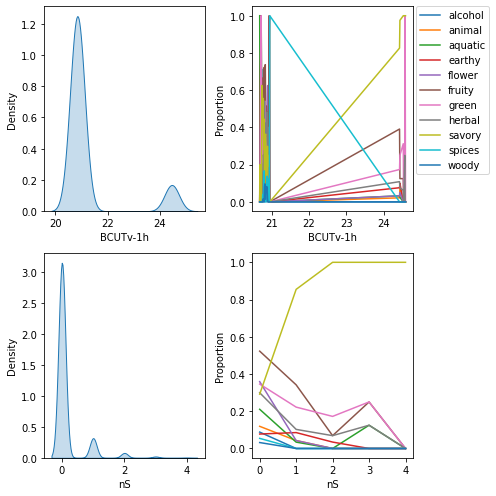

In [124]:
#Create KDE plot of BCUTv-1h feature in the test set with a different color for each class
import seaborn as sns

fig, ax = plt.subplots(2, 2, figsize=(7, 7))

sns.kdeplot(X_test["BCUTv-1h"], ax=ax[0][0], fill=True, palette="crest")

for descriptor in y_test.columns:
    ax[0][1].plot(class_proportions.index, class_proportions[descriptor], label=descriptor)
    ax[0][1].set_xlabel("BCUTv-1h")
    ax[0][1].set_ylabel("Proportion")
    ax[0][1].legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

sns.kdeplot(X_test["nS"], ax=ax[1][0], fill=True, palette="crest")

for descriptor in y_test.columns:
    ax[1][1].plot(class_proportions_ns.index, class_proportions_ns[descriptor], label=descriptor)
    ax[1][1].set_xlabel("nS")
    ax[1][1].set_ylabel("Proportion")

plt.tight_layout()
plt.savefig("../images/FinalModels/kde_plots-most-important-features.png", dpi=300)


Number of correctly predicted savory compounds:  0.6638655462184874
0.0    58.227848
1.0    29.746835
2.0     9.177215
3.0     2.531646
4.0     0.316456
Name: nS, dtype: float64


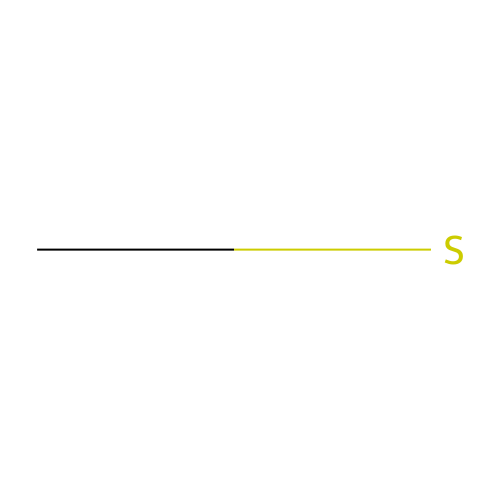

In [167]:
#Get all compounds from savory class in the test set that were correctly predicted by all classifiers
y_hat_tabnet = pd.DataFrame(np.vstack(clf.predict(X_test.values)).T.astype(int), index=X_test.index, columns=y_test.columns)
y_hat_rf = pd.DataFrame(rf.predict(X_test), index=X_test.index, columns=y_test.columns)
y_hat_xgboost = pd.DataFrame(xgboost.predict(X_test), index=X_test.index, columns=y_test.columns)

#Get the compounds for which a correct positive prediction was made by all classifiers for savory class
correctly_predicted = y_test.loc[(y_test["savory"] == 1) & (y_hat_xgboost["savory"] == 1)]

print("Number of correctly predicted savory compounds: ", len(correctly_predicted)/len(y_test.loc[y_test["savory"] == 1]))

#Print nS values of correctly predicted savory compounds
print(X_test.loc[correctly_predicted.index]["nS"].value_counts()/len(correctly_predicted) *100)

#Get mcs of all correctly predicted savory compounds
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import rdFMCS

mols = [Chem.MolFromSmiles(smiles) for smiles in smiles_test.loc[correctly_predicted.index]]

mcs = rdFMCS.FindMCS(mols, timeout=10)

#Draw MCS
from rdkit.Chem import Draw

Draw.MolToImage(mcs_mol, size=(500, 500))


      alcohol    animal   aquatic    earthy    flower    fruity     green  \
0.0  0.115385  0.105128  0.216667  0.083333  0.185897  0.521795   0.34359   
1.0   0.02795  0.111801  0.130435  0.083851       0.5  0.481366  0.335404   
2.0  0.011765  0.076471  0.176471  0.041176  0.558824  0.452941  0.294118   
3.0  0.030303  0.151515  0.242424  0.060606  0.515152   0.30303  0.242424   
4.0       0.0  0.857143       0.0       0.0  0.285714  0.142857       0.0   
5.0       0.0       1.0       0.0       0.0       0.0       0.0       0.0   
6.0       0.0       0.0       0.0       0.0       1.0       0.0       0.0   

       herbal    savory    spices     woody  
0.0  0.221795  0.457692  0.034615  0.029487  
1.0  0.360248  0.245342   0.07764   0.02795  
2.0  0.364706  0.194118  0.064706  0.029412  
3.0   0.30303  0.212121       0.0       0.0  
4.0  0.142857       0.0       0.0       0.0  
5.0       0.0       0.0       0.0       0.0  
6.0       0.0       0.0       0.0       0.0  


Text(0, 0.5, 'Proportion')

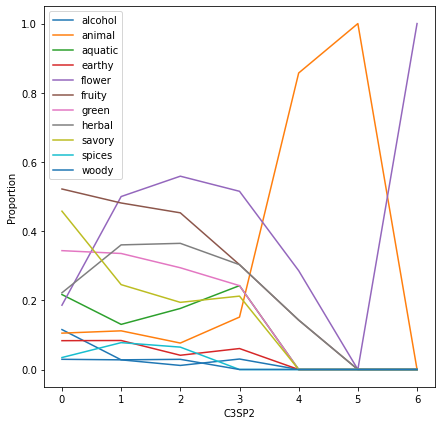

In [132]:
#Get the class proportions at each value for "BCUTv-1h"
C3SP2 = X_test["C3SP2"].values

C3SP2 = np.unique(C3SP2)

class_proportions_C3SP2 = pd.DataFrame(columns=y_test.columns, index=C3SP2)

for i in C3SP2:
    class_proportions_C3SP2.loc[i] = y_test.loc[X_test.index[X_test["C3SP2"] == i]].sum(axis=0)/len(y_test.loc[X_test.index[X_test["C3SP2"] == i]])

print(class_proportions_C3SP2)
#Plot the class proportions at each value for "BCUTv-1h"
fig, ax = plt.subplots(figsize=(7, 7))

for descriptor in y_test.columns:
    ax.plot(class_proportions_C3SP2.index, class_proportions_C3SP2[descriptor], label=descriptor)
    
ax.legend()
ax.set_xlabel("C3SP2")
ax.set_ylabel("Proportion")


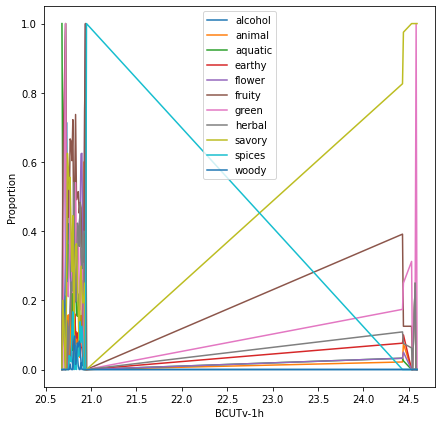

In [115]:
#Get the class proportions at each value for "BCUTv-1h"
BCUTv_1h = X_test["BCUTv-1h"].values
BCUTv_1h = np.round(BCUTv_1h, 2)
BCUTv_1h = np.unique(BCUTv_1h)

class_proportions = pd.DataFrame(columns=y_test.columns, index=BCUTv_1h)

for i in BCUTv_1h:
    class_proportions.loc[i] = y_test.loc[X_test.index[np.round(X_test["BCUTv-1h"], 2) == i]].sum(axis=0)/len(y_test.loc[X_test.index[np.round(X_test["BCUTv-1h"], 2) == i]])

#Plot the class proportions at each value for "BCUTv-1h"
fig, ax = plt.subplots(figsize=(7, 7))

for descriptor in y_test.columns:
    ax.plot(class_proportions.index, class_proportions[descriptor], label=descriptor)
    
ax.legend()
ax.set_xlabel("BCUTv-1h")
ax.set_ylabel("Proportion")

plt.savefig("../images/class_proportions-bcutv-1h.png", dpi=300)

Text(0, 0.5, 'BCUTv-1h')

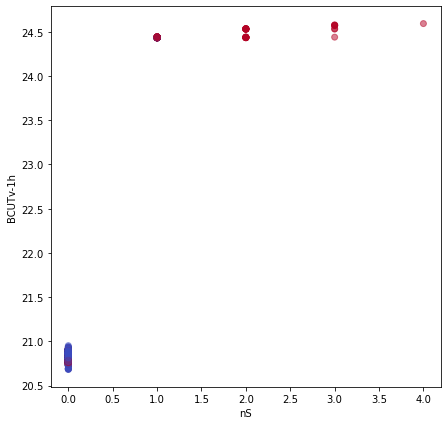

In [161]:
#Scatter plot of nS vs BCUTv-1h
fig, ax = plt.subplots(figsize=(7, 7))

ax.scatter(X_test["nS"], X_test["BCUTv-1h"], c=y_test["savory"], cmap="coolwarm", alpha=0.5)
ax.set_xlabel("nS")
ax.set_ylabel("BCUTv-1h")

In [ ]:
#Find

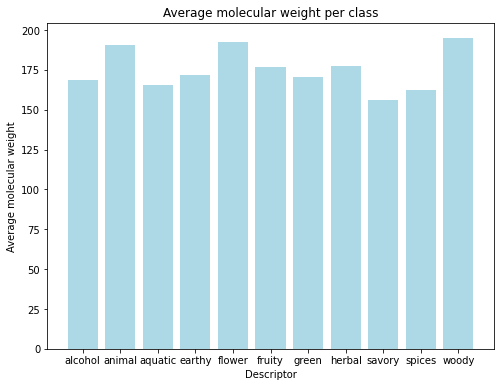

In [179]:
mol_weights = pd.read_csv("Data_set/data_split/test.csv", index_col=0)
mol_weights = mol_weights["MolecularWeight"]	

#Calculate the average molecular weight of the test set per class
avg_mol_weight = []
for descriptor in y_test.columns:
    avg_mol_weight.append(np.mean(mol_weights.loc[y_test.index[y_test[descriptor] == 1]]))

#Plot the average molecular weight per class
plt.figure(figsize=(8, 6))
plt.bar(y_test.columns, avg_mol_weight, color="lightblue")
plt.xlabel("Descriptor")
plt.ylabel("Average molecular weight")
plt.title("Average molecular weight per class")
plt.savefig("../images/FinalModels/avg_mol_weight_per_class.png", dpi=300)
plt.show()

In [180]:
# import pickle

# #Save the model
# pickled_tabnet = pickle.dumps(clf)
# pickled_xgboost = pickle.dumps(xgboost)
# pickled_rf = pickle.dumps(rf)
# pickled_tabnet_original = pickle.dumps(tabnet_original)
# pickled_xgboost_original = pickle.dumps(xgboost_original)
# pickled_rf_original = pickle.dumps(rf_original)

# #Save the pickled model
# with open('Data_set/Models/FinalModels/pickled_tabnet.pkl', 'wb') as f:
#     f.write(pickled_tabnet)

# with open('Data_set/Models/FinalModels/pickled_xgboost.pkl', 'wb') as f:
#     f.write(pickled_xgboost)

# with open('Data_set/Models/FinalModels/pickled_rf.pkl', 'wb') as f:
#     f.write(pickled_rf)

# with open('Data_set/Models/FinalModels/pickled_tabnet_original.pkl', 'wb') as f:
#     f.write(pickled_tabnet_original)

# with open('Data_set/mask_tabnet = shap.maskers.Independent(mols_to_analyze)

# explainer_tabnet = shap.KernelExplainer(f, mols_to_analyze, mask=mask_tabnet)
# shap_explanations_tabnet = explainer_tabnet(mols_to_analyze)Models/FinalModels/pickled_xgboost_original.pkl', 'wb') as f:
#     f.write(pickled_xgboost_original)

# with open('Data_set/Models/FinalModels/pickled_rf_original.pkl', 'wb') as f:
    # f.write(pickled_rf_original)


In [166]:
#XGBoost importance gain,cover and weight of nS and BCUTv-1h
gain = xgboost.get_booster().get_score(importance_type="gain")
cover = xgboost.get_booster().get_score(importance_type="cover")
weight = xgboost.get_booster().get_score(importance_type="weight")

print("GAIN of nS: ", gain["nS"])
print("COVER of nS: ", cover["nS"])
print("WEIGHT of nS: ", weight["nS"])

print("GAIN of BCUTv-1h: ", gain["BCUTv-1h"])
print("COVER of BCUTv-1h: ", cover["BCUTv-1h"])
print("WEIGHT of BCUTv-1h: ", weight["BCUTv-1h"])

GAIN of nS:  61.34851837158203
COVER of nS:  287.7076721191406
WEIGHT of nS:  10.0
GAIN of BCUTv-1h:  1.39378023147583
COVER of BCUTv-1h:  71.21734619140625
WEIGHT of BCUTv-1h:  4671.0


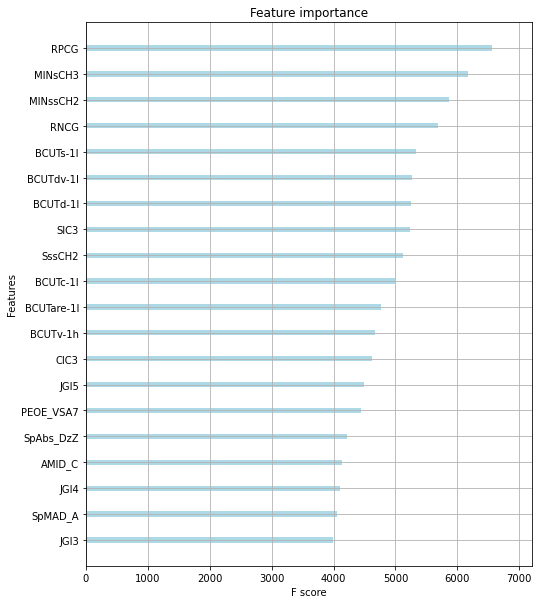

In [163]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 10))

plot_importance(xgboost, ax=ax, importance_type='weight', max_num_features=20, show_values=False, color='lightblue')
plt.savefig("../images/FinalModels/feature_weight_xgboost.png", dpi=300)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
 98%|===================| 1292/1314 [00:57<00:00]        

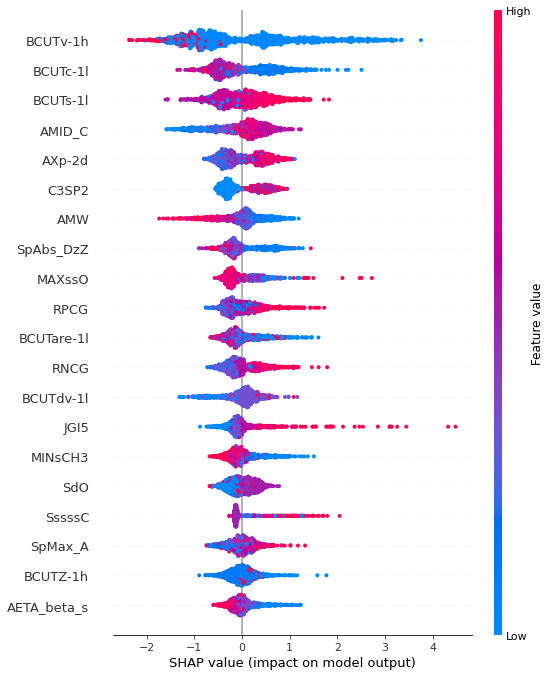

In [16]:
import shap

mask = shap.maskers.Independent(X_test, max_samples=1000)

explainer_xgb = shap.TreeExplainer(xgboost, mask)
shap_explanations_xgb = explainer_xgb(X_test)
shap_values_xgb = shap_explanations_xgb.values

shap.summary_plot(shap_explanations_xgb, X_test, class_names=y_test.columns,title="SHAP Summary Plot of XGBoost", max_display=20, feature_names=X_test.columns)

In [17]:
shap_values_xgb.shape

(1314, 78)

In [191]:
y_test.index.get_loc(X_test["nS"].loc[X_test["nS"] == 4].index.values[0])

778

Actual:          alcohol  animal  aquatic  earthy  flower  fruity  green  herbal  \
CID                                                                       
593529        0       0        0       0       0       0      0       0   

        savory  spices  woody  
CID                            
593529       1       0      0  
Predicted:          alcohol  animal  aquatic  earthy  flower  fruity  green  herbal  \
CID                                                                       
593529      0.0     0.0      0.0     0.0     0.0     0.0    0.0     0.0   

        savory  spices  woody  
CID                            
593529     1.0     0.0    0.0  


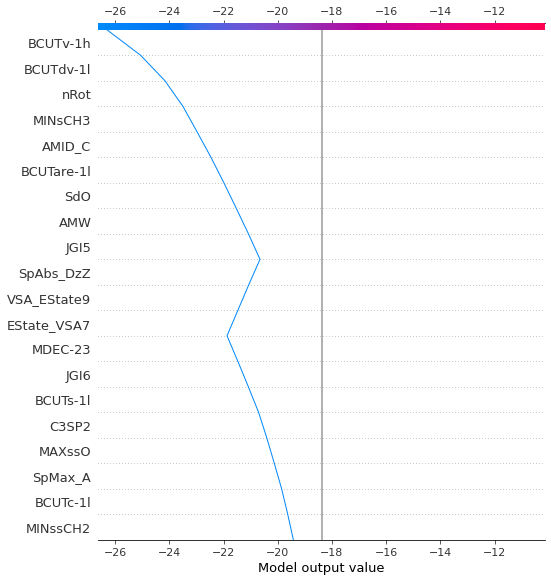

In [198]:
#Get all compounds with nS = 4
nS_4 = X_test["nS"].loc[X_test["nS"] == 4].index.values

print("Actual: ", y_test.loc[nS_4])
print("Predicted: ", y_hat_xgboost.loc[nS_4])

#Retrieve integer index from y_test for nS = 4
nS_4_index =X_test.index.get_loc(nS_4[0])

shap_values = shap_explanations_xgb[nS_4_index].values

#Plot the SHAP decision plot for nS = 4
shap.decision_plot(explainer_xgb.expected_value, shap_values, features=X_test.columns)
# shap.plots.waterfall(shap_explanations_xgb[nS_4_index], max_display=40)

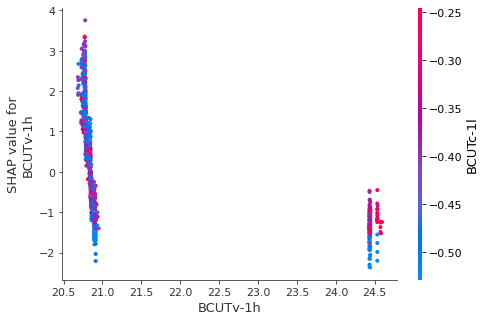

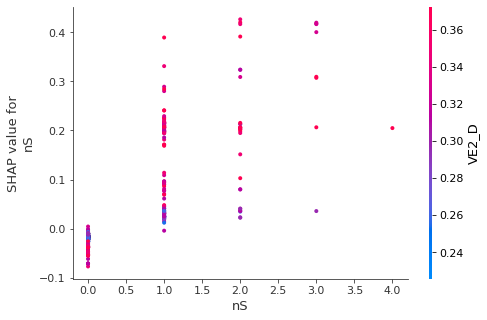

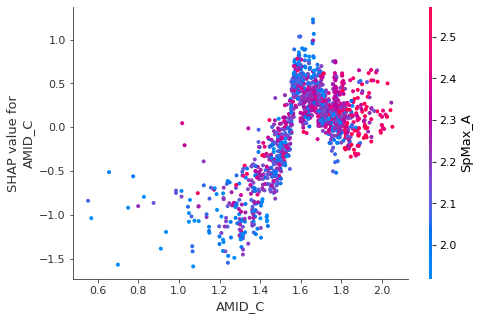

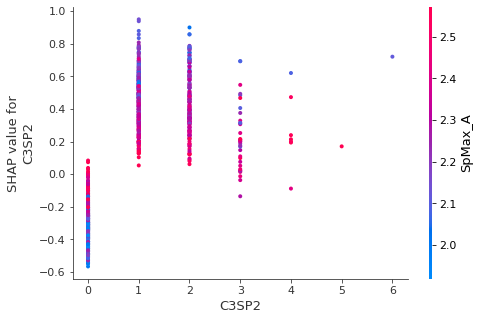

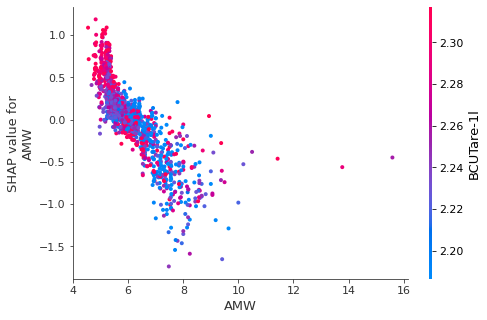

In [19]:
shap.dependence_plot("BCUTv-1h", shap_values_xgb, X_test)
shap.dependence_plot("nS", shap_values_xgb, X_test)
shap.dependence_plot("AMID_C", shap_values_xgb, X_test)
shap.dependence_plot("C3SP2", shap_values_xgb, X_test)
shap.dependence_plot("AMW", shap_values_xgb, X_test)

In [ ]:
import warnings

expected_value = explainer_xgb.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

select = range(100)
features = X_test.iloc[select]
targets = y_test.iloc[select]
print(len(features))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer_xgb.shap_values(features)

Explainer expected value: -18.384870603212303
100


In [ ]:
y_hat = xgboost.predict(features)
correct = y_hat == targets
correct = correct.reset_index(drop=True)
correct = correct.sum(axis=1) == 11
correct = correct.where(correct == True).dropna().index
shap_values = shap_values[correct]
correct

Int64Index([0, 8, 9, 12, 13, 14, 21, 22, 32, 44, 58, 68, 76, 86, 89, 90], dtype='int64')

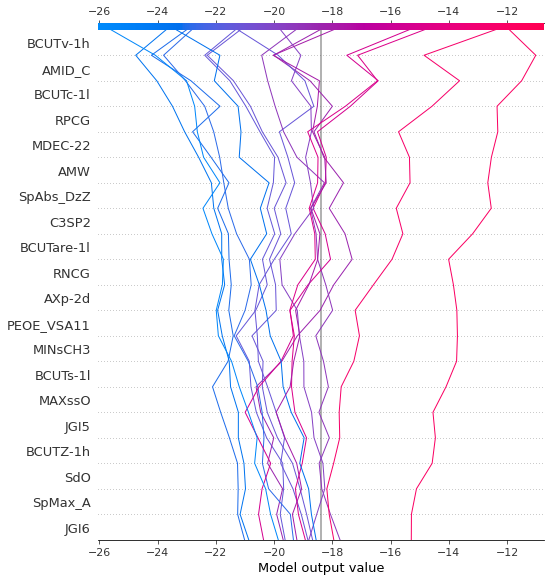

In [ ]:
shap.decision_plot(expected_value, shap_values, features=features.columns)

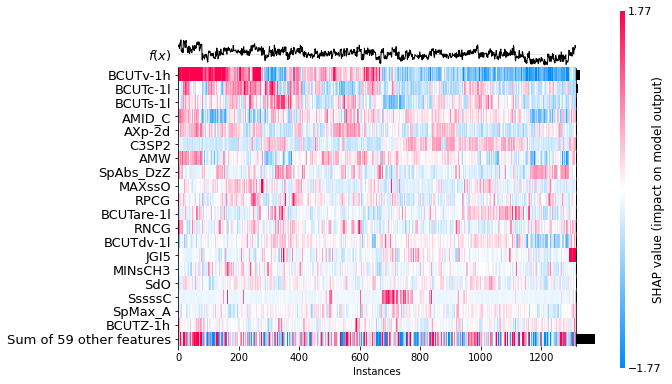

In [ ]:
shap.plots.heatmap(shap_explanations_xgb, max_display=20)

In [79]:
y_hat = rf.predict(X_test)
y_hat.shape

(1314, 11)

In [83]:
from sklearn.metrics import multilabel_confusion_matrix, ConfusionMatrixDisplay

mcm = multilabel_confusion_matrix(y_test, y_hat)

#Convert to percentages
mcm = np.array([i/len(y_test) for i in mcm])

for i in range(11):
    disp = ConfusionMatrixDisplay(mcm[i], display_labels=[0, 1], colorbar=False)
    disp.plot()
    plt.title(y_test.columns[i])
    plt.savefig(f"../images/FinalModels/confusion_matrix_{y_test.columns[i]}-rf.png", dpi=300)
    plt.show()

TypeError: __init__() got an unexpected keyword argument 'colorbar'

alcohol    0
animal     0
aquatic    0
earthy     0
flower     0
fruity     1
green      0
herbal     0
savory     0
spices     0
woody      0
Name: 10877566, dtype: int64


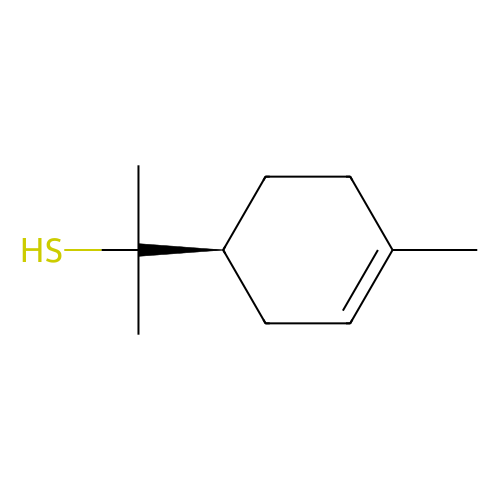

In [ ]:
#Find the index of the sample with the highest variance in shape values
index = np.argmax(np.var(shap_values_xgb, axis=1))

#Draw the molecule corresponding to that sample
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles(smiles_test.iloc[index])

#Draw the molecule
print(y_test.iloc[index])
Draw.MolToImage(mol, size=(500, 500))

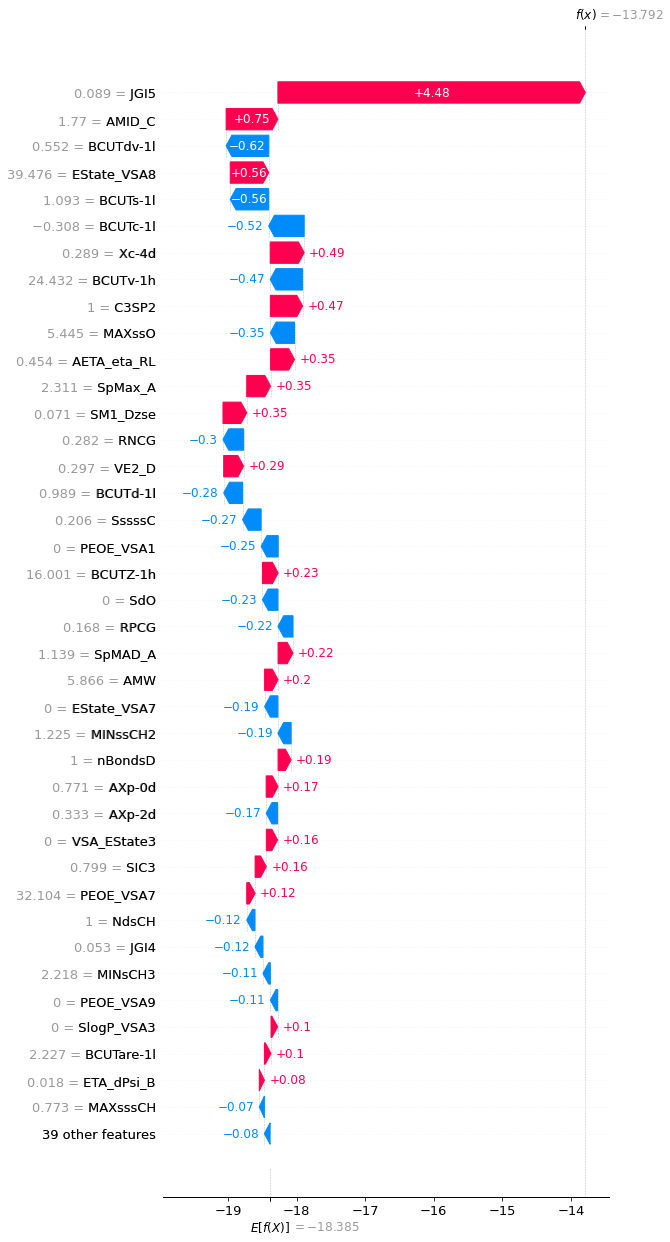

In [ ]:
#Plot the shap values for that sample
shap.plots.waterfall(shap_explanations_xgb[index], max_display=40)

In [ ]:
def perf_measure(y_actual, y_pred):
    TP = []
    FP = []
    TN = []
    FN = []

    for i in range(len(y_pred)): 
        if y_actual.iloc[i]==y_pred.iloc[i]==1:
           TP.append(i)
        if y_pred.iloc[i]==1 and y_actual.iloc[i]!=y_pred.iloc[i]:
           FP.append(i)
        if y_actual.iloc[i]==y_pred.iloc[i]==0:
           TN.append(i)
        if y_pred.iloc[i]==0 and y_actual.iloc[i]!=y_pred.iloc[i]:
           FN.append(i)

    return (TP, FP, TN, FN)

In [213]:
from random import sample

# def f(X):
#     return np.vstack(clf.predict(X)).T.astype(int)

# mols_to_analyze = []
# y_hat = pd.DataFrame(np.vstack(clf.predict(X_test.values)).T.astype(int), columns=y_test.columns, index=y_test.index)


# for label in y_test.columns:
#     #Get true positives from y_test and y_hat
#     result = perf_measure(y_test[label], y_hat[label])

#     #Add 4 molecules from each class to mols_to_analyze
#     for l in result:
#         if len(l) > 0:
#             mols_to_analyze += sample(l, 4)

# print(len(mols_to_analyze))

mols_to_analyze = X_test.iloc[[nS_4_index, 1, 2]]

explainer_tabnet = shap.KernelExplainer(f, mols_to_analyze)
shap_explanations_tabnet = explainer_tabnet(mols_to_analyze)

  0%|          | 0/3 [00:00<?, ?it/s]

divide by zero encountered in log
invalid value encountered in true_divide
divide by zero encountered in log
invalid value encountered in true_divide


In [214]:
shap_values_tabnet = explainer_tabnet.shap_values(mols_to_analyze)

  0%|          | 0/3 [00:00<?, ?it/s]

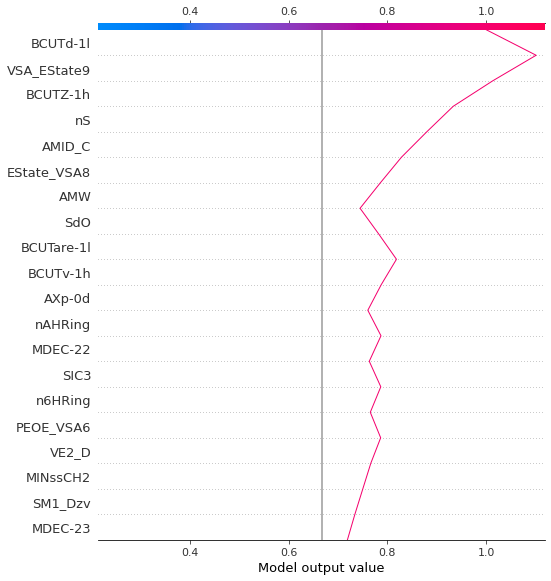

In [216]:
shap.decision_plot(explainer_tabnet.expected_value[8], shap_values_tabnet[8][0], features=X_test.columns)

In [ ]:
shap_values_tabnet = shap_explanations_tabnet.values
y_hat = pd.DataFrame(np.vstack(clf.predict(X_test.values)).T.astype(int), columns=y_test.columns, index=y_test.index)

In [ ]:
shap_values_tabnet.shape

(176, 78, 11)

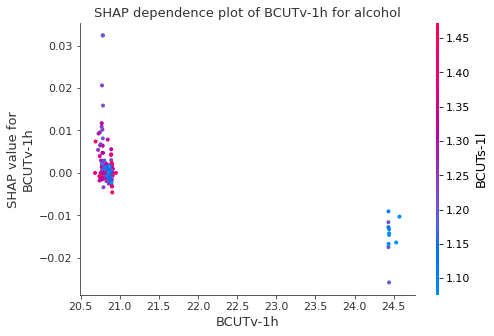

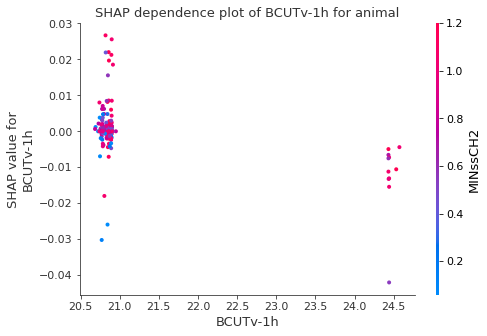

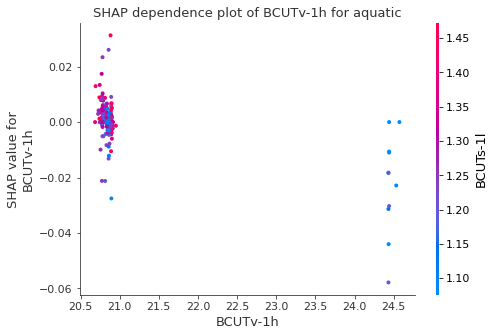

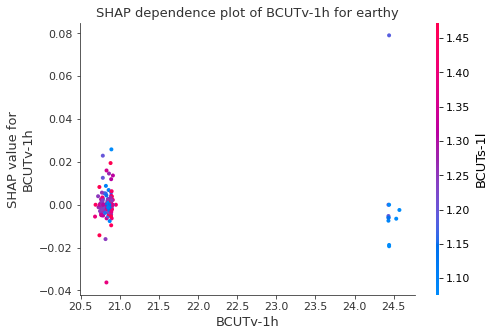

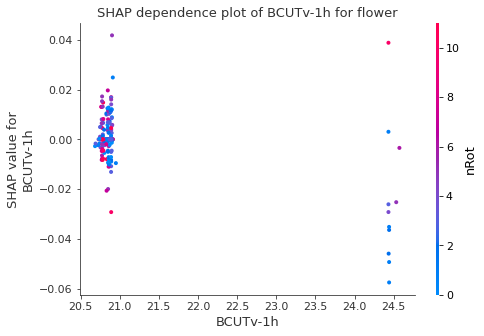

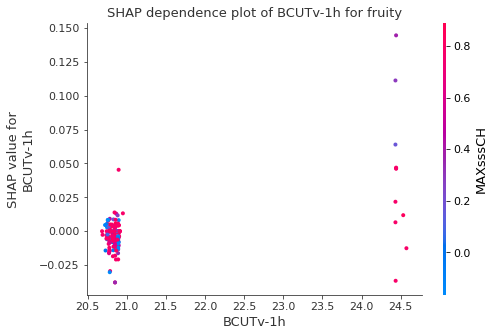

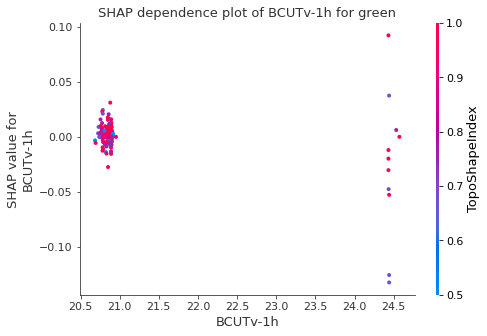

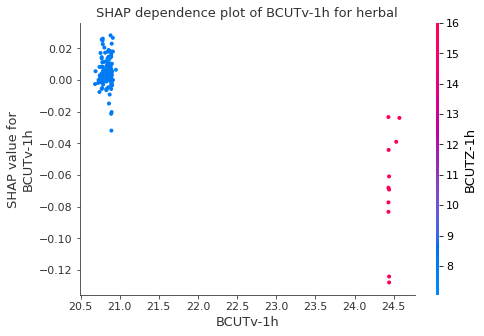

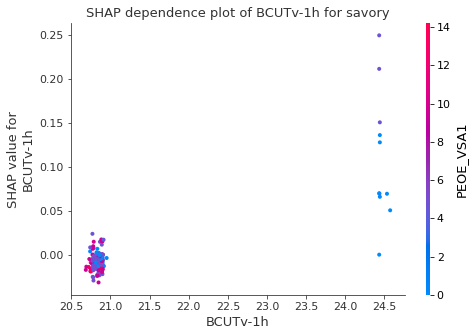

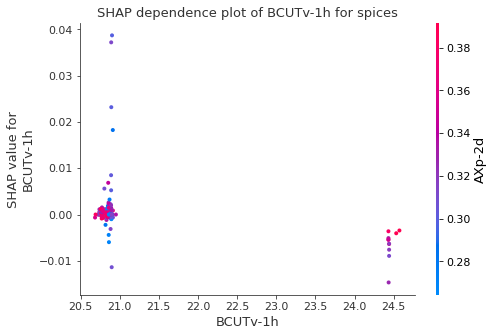

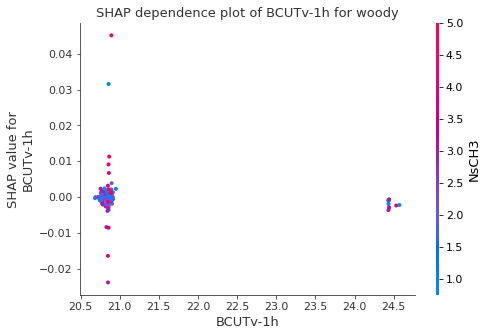

In [ ]:
for i in range(11):
    shap.dependence_plot("BCUTv-1h", shap_values_tabnet[:,:,i], X_test.loc[mols_to_analyze.index], title=f"SHAP dependence plot of BCUTv-1h for {y_test.columns[i]}", show=False)
    plt.savefig(f"../images/FinalModels/shap_depend_tabnet/BCUTv-1h_{y_test.columns[i]}.png", dpi=300)

In [ ]:
y_test.iloc[len(y_test)-1]

alcohol    0
animal     0
aquatic    0
earthy     0
flower     1
fruity     0
green      1
herbal     0
savory     0
spices     0
woody      0
Name: 163709488, dtype: int64

Explainer expected value: [0.10227273 0.10795455 0.15340909 0.09659091 0.29545455 0.47727273
 0.41477273 0.30113636 0.34090909 0.0625     0.05681818]
78
Selected mols [0, 1, 2, 3, 39, 45, 46, 99, 130, 4, 5, 6, 7, 55, 94, 118, 119, 128, 8, 9, 10, 11, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 40, 41, 42, 43, 44, 48, 49, 50, 51, 53, 54, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 97, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 120, 121, 122, 123, 124, 125, 126, 127, 129, 131, 132, 133, 134, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175]
SHAP values shape (165, 78)
Features shape (176, 78)
Selected mols shape 165


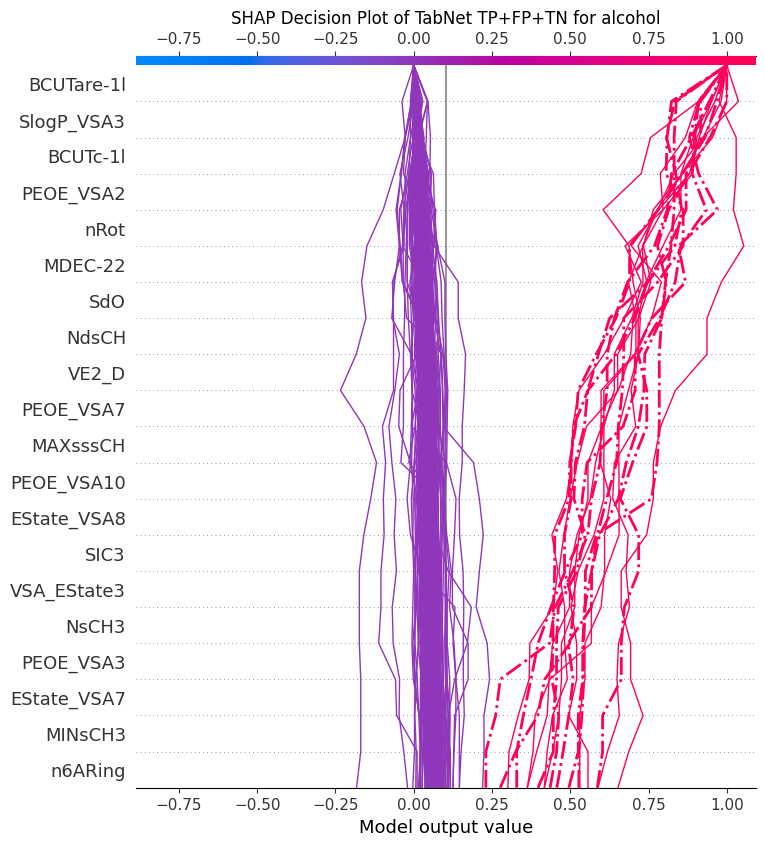

Selected mols [16, 17, 18, 19, 88, 107, 137, 12, 20, 21, 22, 23, 35, 54, 74, 90, 105, 158, 171, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 24, 25, 26, 27, 32, 33, 34, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 55, 56, 57, 59, 60, 61, 63, 64, 65, 67, 68, 69, 70, 71, 72, 75, 76, 77, 78, 79, 80, 81, 82, 83, 85, 86, 87, 89, 91, 93, 94, 95, 96, 97, 98, 99, 102, 103, 106, 108, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 160, 162, 163, 164, 165, 166, 167, 168, 169, 170, 172, 173, 174]
SHAP values shape (157, 78)
Features shape (176, 78)
Selected mols shape 157


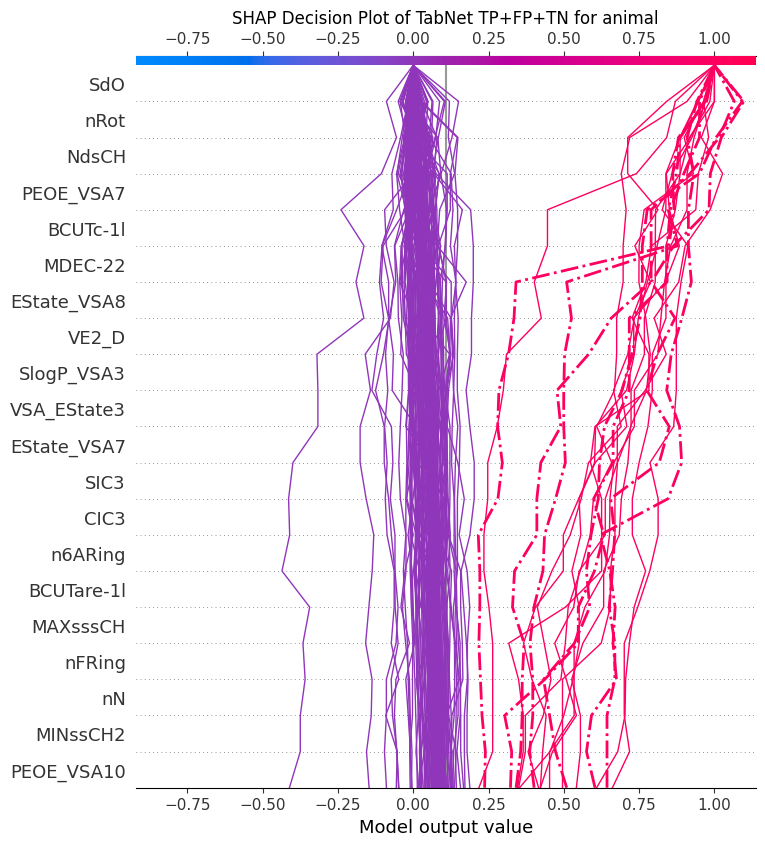

Selected mols [1, 2, 3, 15, 32, 33, 34, 35, 48, 110, 123, 131, 142, 156, 10, 36, 37, 38, 39, 54, 58, 61, 81, 100, 129, 130, 166, 4, 5, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 40, 41, 42, 43, 49, 50, 51, 52, 53, 55, 56, 59, 60, 62, 63, 65, 66, 67, 69, 70, 71, 72, 73, 75, 76, 77, 78, 80, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 95, 97, 98, 99, 101, 103, 104, 105, 107, 108, 109, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 128, 132, 133, 134, 135, 136, 137, 138, 139, 140, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 157, 158, 159, 160, 161, 162, 163, 164, 165, 167, 168, 170, 171, 172, 173, 174, 175]
SHAP values shape (154, 78)
Features shape (176, 78)
Selected mols shape 154


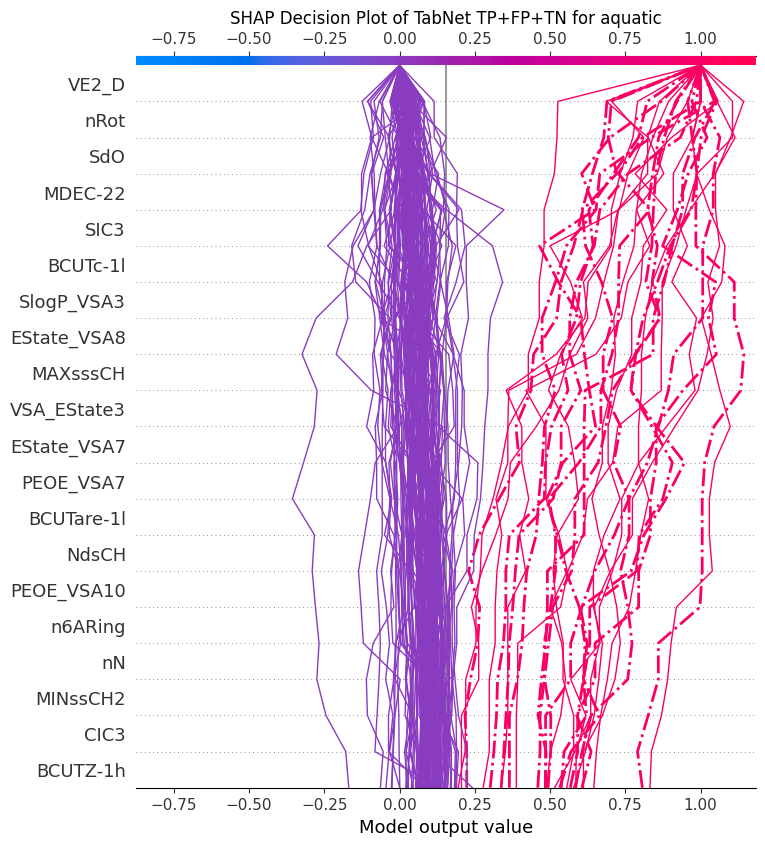

Selected mols [43, 48, 49, 50, 51, 113, 0, 11, 19, 37, 52, 53, 54, 55, 69, 70, 89, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 44, 45, 46, 47, 56, 57, 58, 59, 64, 65, 66, 67, 68, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 95, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175]
SHAP values shape (166, 78)
Features shape (176, 78)
Selected mols shape 166


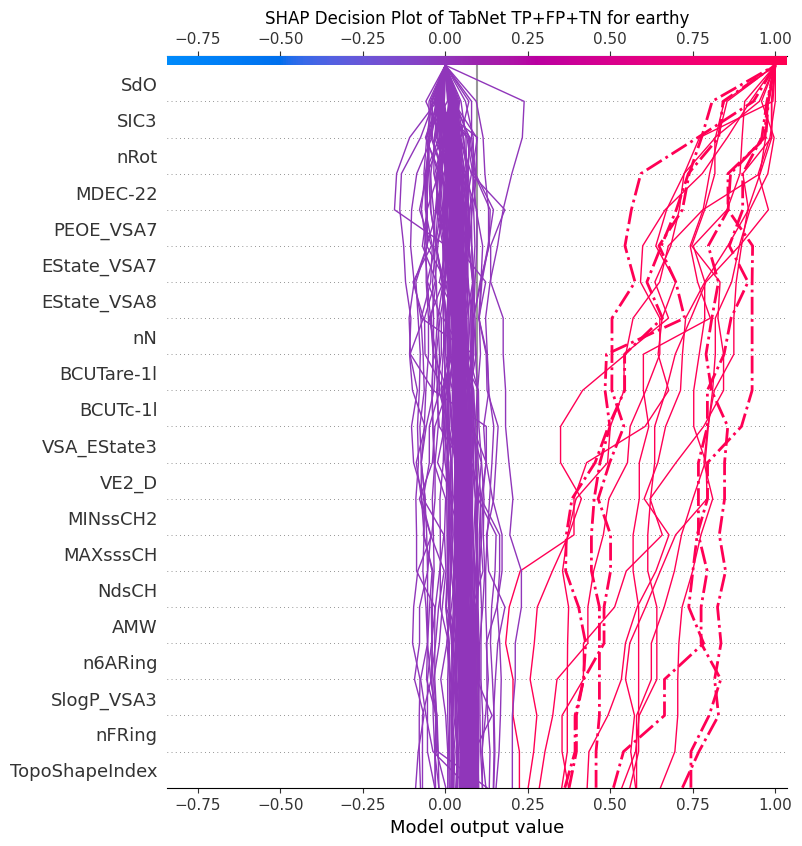

Selected mols [8, 10, 17, 30, 31, 33, 55, 56, 57, 64, 65, 66, 67, 82, 84, 102, 104, 105, 109, 110, 123, 125, 133, 134, 150, 151, 154, 156, 158, 159, 169, 172, 24, 32, 35, 45, 62, 68, 69, 70, 71, 93, 95, 114, 115, 136, 140, 142, 148, 157, 163, 167, 1, 2, 3, 5, 6, 7, 9, 12, 14, 16, 18, 19, 20, 22, 23, 26, 27, 28, 29, 34, 36, 37, 39, 40, 41, 43, 46, 47, 48, 50, 51, 53, 54, 58, 60, 61, 63, 72, 73, 74, 75, 81, 83, 85, 86, 87, 88, 89, 90, 91, 92, 94, 96, 97, 98, 99, 100, 101, 103, 107, 108, 112, 119, 120, 121, 122, 124, 126, 127, 128, 129, 130, 131, 135, 137, 138, 139, 141, 143, 145, 146, 147, 149, 152, 153, 155, 160, 161, 162, 164, 165, 173, 174, 175]
SHAP values shape (146, 78)
Features shape (176, 78)
Selected mols shape 146


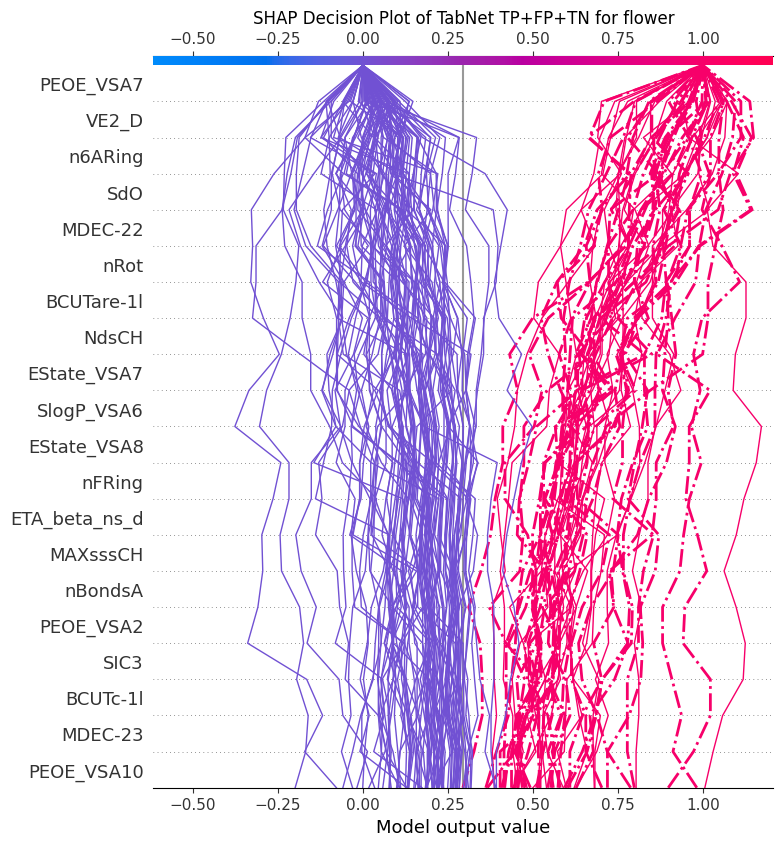

Selected mols [0, 4, 5, 6, 7, 13, 14, 15, 20, 24, 25, 30, 31, 32, 34, 35, 38, 42, 44, 45, 46, 52, 56, 60, 63, 64, 65, 66, 68, 74, 79, 80, 81, 82, 83, 96, 97, 98, 100, 102, 106, 110, 115, 118, 119, 122, 125, 128, 129, 135, 139, 141, 154, 157, 158, 159, 162, 168, 171, 172, 8, 12, 37, 55, 62, 77, 84, 85, 86, 87, 101, 112, 114, 117, 124, 126, 130, 134, 138, 143, 155, 163, 170, 173, 1, 2, 3, 11, 16, 18, 19, 21, 22, 23, 26, 27, 29, 33, 36, 40, 41, 43, 47, 48, 49, 50, 51, 53, 57, 58, 59, 61, 67, 69, 70, 72, 73, 75, 78, 88, 89, 90, 91, 99, 104, 105, 108, 109, 113, 116, 120, 121, 123, 127, 133, 136, 137, 140, 142, 144, 146, 147, 148, 149, 150, 151, 152, 153, 156, 160, 161, 164, 165, 166, 167, 169, 174, 175]
SHAP values shape (158, 78)
Features shape (176, 78)
Selected mols shape 158


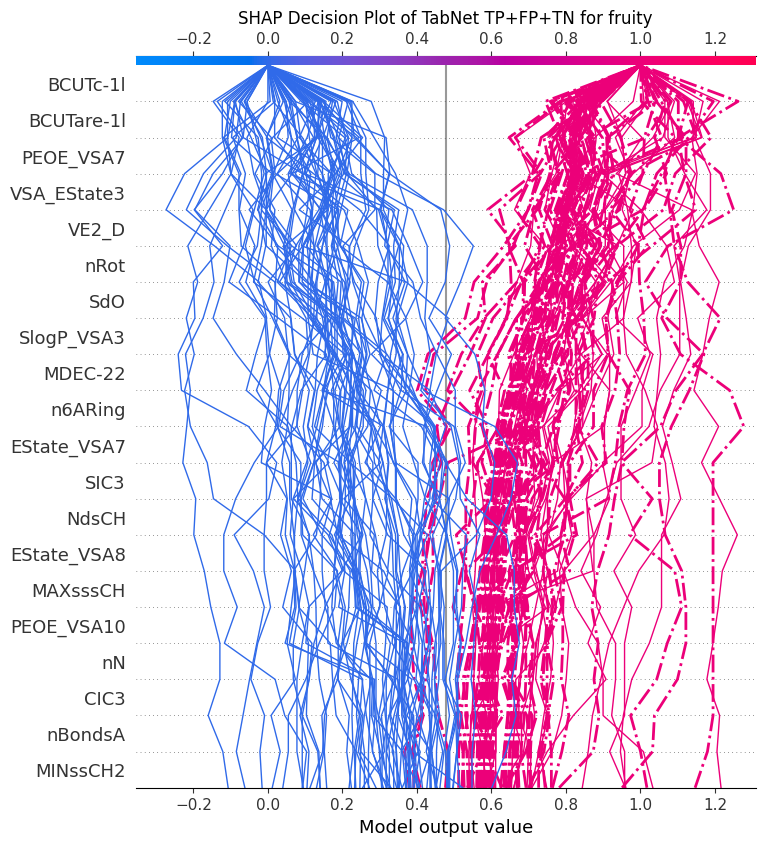

Selected mols [1, 3, 14, 15, 25, 32, 38, 39, 40, 46, 50, 51, 57, 62, 68, 70, 87, 96, 97, 98, 99, 119, 122, 125, 128, 131, 138, 141, 142, 143, 169, 172, 0, 2, 6, 10, 11, 19, 22, 29, 34, 37, 42, 45, 53, 55, 58, 59, 60, 61, 67, 69, 73, 76, 78, 81, 83, 85, 89, 93, 94, 100, 101, 102, 103, 118, 124, 127, 129, 130, 139, 166, 168, 4, 5, 7, 8, 9, 12, 13, 16, 17, 18, 20, 21, 23, 26, 27, 28, 30, 31, 36, 41, 43, 44, 47, 49, 54, 56, 64, 65, 66, 71, 72, 74, 75, 84, 86, 88, 90, 91, 92, 95, 104, 105, 106, 107, 112, 113, 116, 120, 121, 123, 126, 132, 133, 134, 135, 136, 140, 144, 145, 146, 147, 148, 149, 150, 151, 153, 154, 155, 156, 158, 160, 161, 162, 163, 164, 165, 171, 173, 174, 175]
SHAP values shape (153, 78)
Features shape (176, 78)
Selected mols shape 153


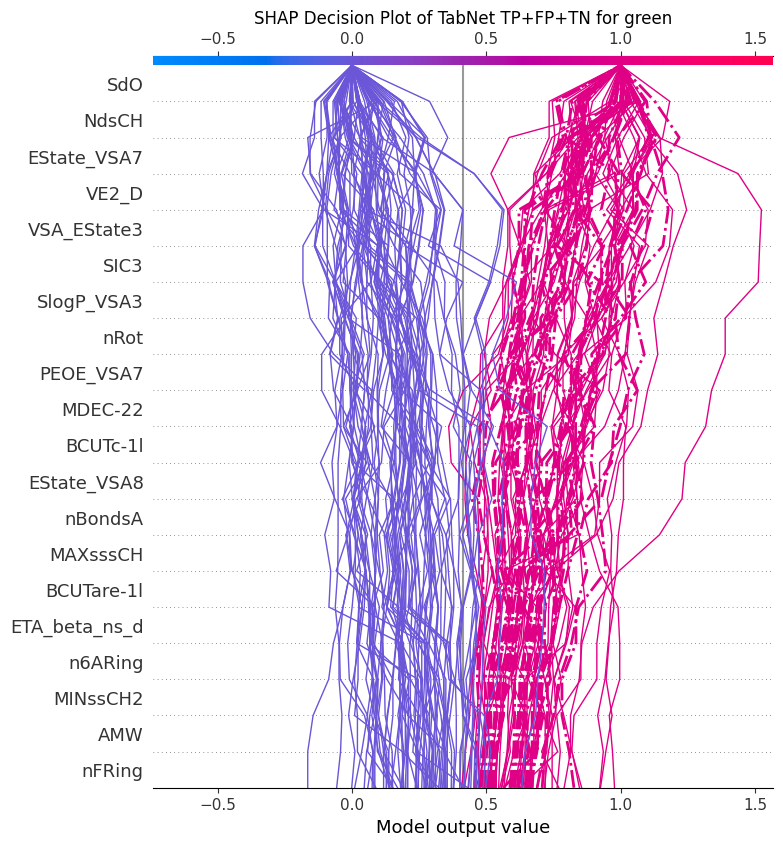

Selected mols [15, 23, 25, 29, 37, 40, 45, 53, 55, 57, 61, 75, 92, 94, 112, 113, 114, 115, 133, 137, 139, 157, 159, 162, 164, 167, 169, 173, 0, 21, 22, 35, 43, 49, 52, 58, 65, 76, 77, 81, 84, 91, 116, 117, 118, 119, 128, 134, 136, 138, 161, 170, 174, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 18, 20, 24, 26, 27, 28, 30, 31, 33, 34, 36, 38, 39, 41, 42, 46, 50, 51, 54, 59, 60, 62, 63, 66, 67, 68, 69, 70, 71, 72, 73, 74, 78, 79, 80, 82, 83, 85, 87, 88, 89, 93, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 108, 109, 110, 111, 120, 121, 122, 123, 129, 130, 131, 135, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 158, 160, 165, 166, 171, 172]
SHAP values shape (155, 78)
Features shape (176, 78)
Selected mols shape 155


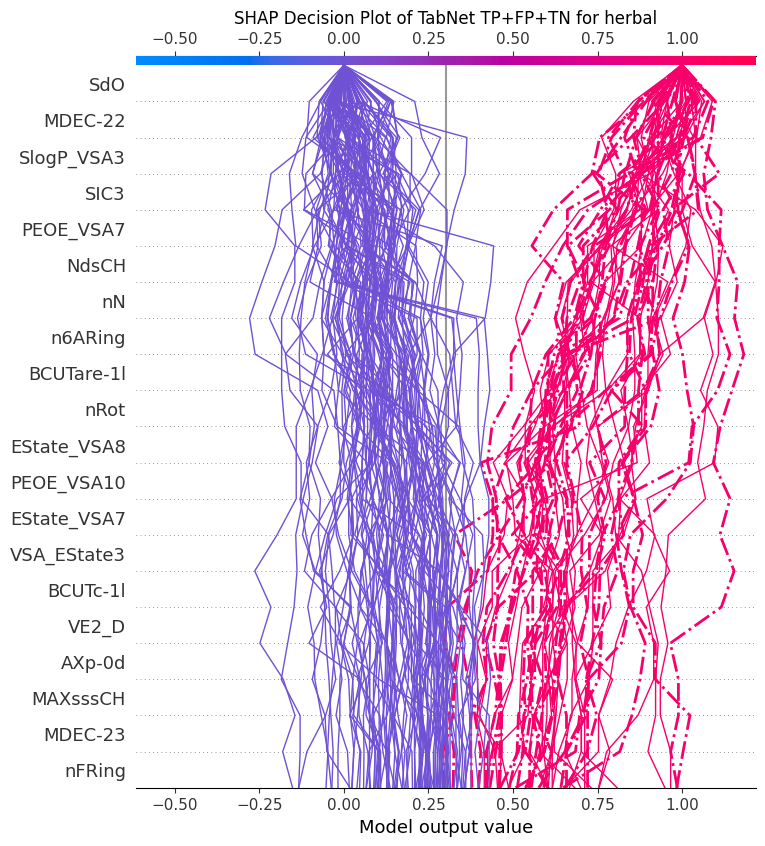

Selected mols [1, 3, 9, 15, 20, 22, 23, 26, 30, 36, 38, 41, 50, 53, 54, 63, 66, 72, 74, 86, 91, 99, 100, 101, 115, 119, 120, 121, 124, 128, 129, 130, 131, 144, 147, 153, 155, 0, 2, 4, 11, 12, 28, 42, 47, 51, 55, 59, 83, 87, 89, 94, 112, 123, 132, 133, 134, 135, 156, 158, 5, 6, 7, 8, 10, 13, 16, 17, 18, 19, 21, 24, 25, 29, 31, 32, 33, 34, 35, 37, 39, 40, 43, 44, 45, 48, 49, 52, 56, 57, 58, 60, 61, 62, 64, 65, 67, 68, 73, 76, 77, 78, 79, 80, 82, 84, 88, 90, 93, 95, 96, 97, 98, 102, 103, 104, 105, 106, 108, 109, 110, 113, 117, 118, 122, 125, 126, 127, 136, 137, 138, 139, 145, 150, 151, 152, 154, 157, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 173, 174, 175]
SHAP values shape (152, 78)
Features shape (176, 78)
Selected mols shape 152


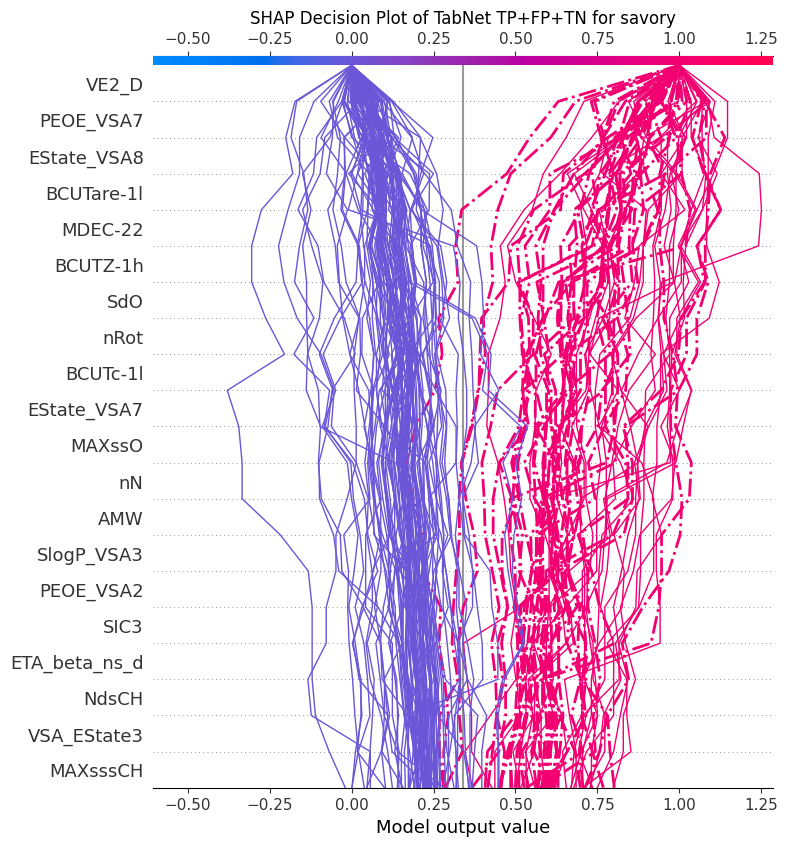

Selected mols [144, 145, 146, 147, 27, 75, 134, 148, 149, 150, 151, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 143, 152, 153, 154, 155, 160, 161, 162, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175]
SHAP values shape (168, 78)
Features shape (176, 78)
Selected mols shape 168


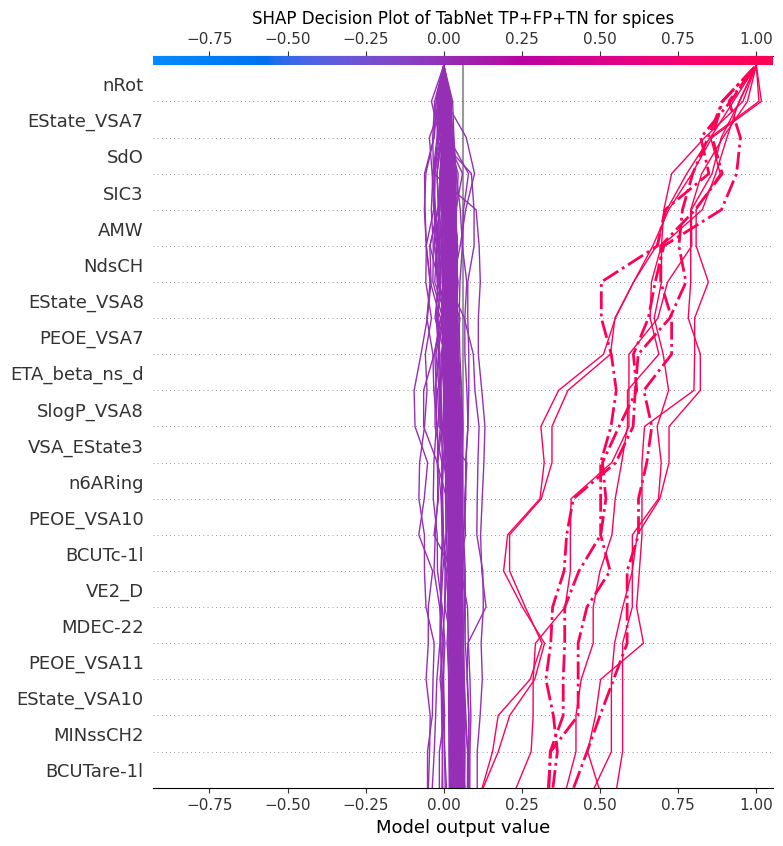

Selected mols [88, 160, 161, 162, 163, 58, 164, 165, 166, 167, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 128, 129, 130, 131, 132, 133, 134, 135, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 168, 169, 170, 171]
SHAP values shape (169, 78)
Features shape (176, 78)
Selected mols shape 169


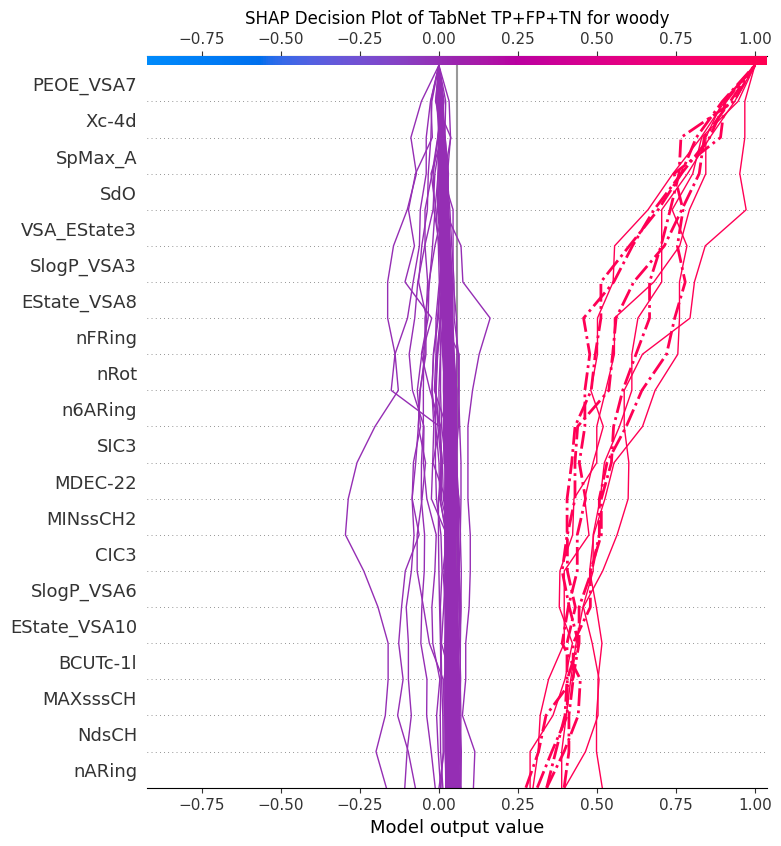

In [ ]:
import warnings

expected_value = explainer_tabnet.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

features = X_test.loc[mols_to_analyze.index]
print(len(features.columns))
targets = y_test.loc[mols_to_analyze.index]


classes = y_hat.columns

for i in range(len(classes)):
    #Get true positives from y_test and y_hat
    perf = perf_measure(y_test.loc[mols_to_analyze.index][classes[i]], y_hat.loc[mols_to_analyze.index][classes[i]])

    selected_mols = perf[0] + perf[1] +perf[2]

    print("Selected mols", selected_mols)

    values = shap_values_tabnet[selected_mols, :, i]

    print("SHAP values shape", values.shape)
    print("Features shape", features.shape)
    print("Selected mols shape", len(selected_mols))

    shap.decision_plot(expected_value[i], values, features=features.columns, show=True, title=f"SHAP Decision Plot of TabNet TP+FP+TN for {classes[i]}", highlight=range(len(perf[0])))


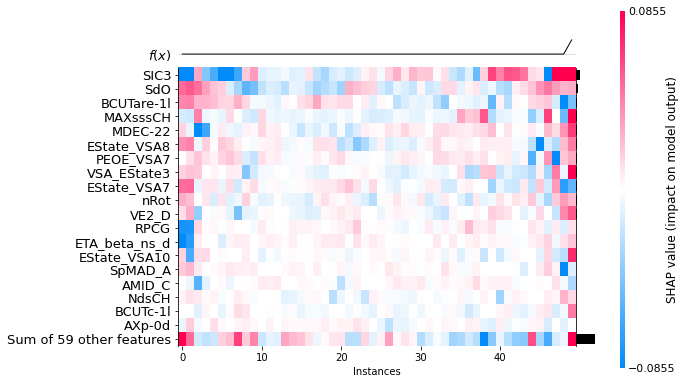

In [ ]:
shap.plots.heatmap(shap_explanations_tabnet[:,:,3], max_display=20)

alcohol    0
animal     0
aquatic    0
earthy     0
flower     0
fruity     0
green      0
herbal     0
savory     1
spices     0
woody      0
Name: 525, dtype: int64


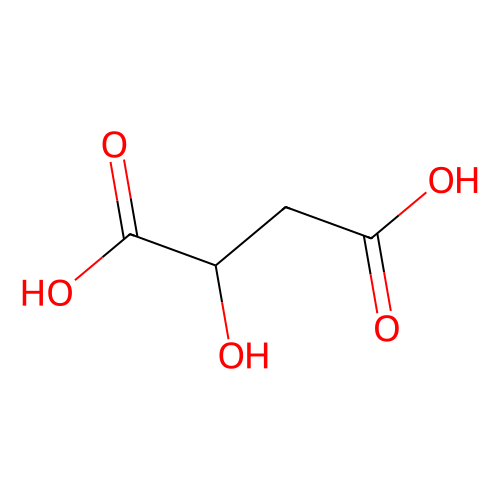

In [ ]:
#Find the index of the sample with the highest variance in shape values
shape_values_tabnet_0 = shap_explanations_tabnet[:,:,0].values
index = np.argmax(np.var(shape_values_tabnet_0, axis=1))

#Draw the molecule corresponding to that sample
import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
mol = Chem.MolFromSmiles(smiles_test.iloc[index])

#Draw the molecule
print(y_test.iloc[index])
Draw.MolToImage(mol, size=(500, 500))

In [ ]:
import ipywidgets as widgets
X_idx = 0


list_of_labels = list(y_train.columns)
tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))
current_label = widgets.Dropdown(options=tuple_of_labels,
                              value=0,
                              description='Select Label:'
                              )

current_label

# print the JS visualization code to the notebook
shap.initjs()

print(f'Current label Shown: {list_of_labels[current_label.value]}')


shap.force_plot(base_value = explainer_xgb.expected_value[current_label.value],
                shap_values = shap_values[current_label.value],
                features = X_train.iloc[X_idx:X_idx+1,:]
                )

Dropdown(description='Select Label:', options=(('alcohol', 0), ('animal', 1), ('aquatic', 2), ('earthy', 3), (…

Current label Shown: herbal


IndexError: index 1 is out of bounds for axis 0 with size 1

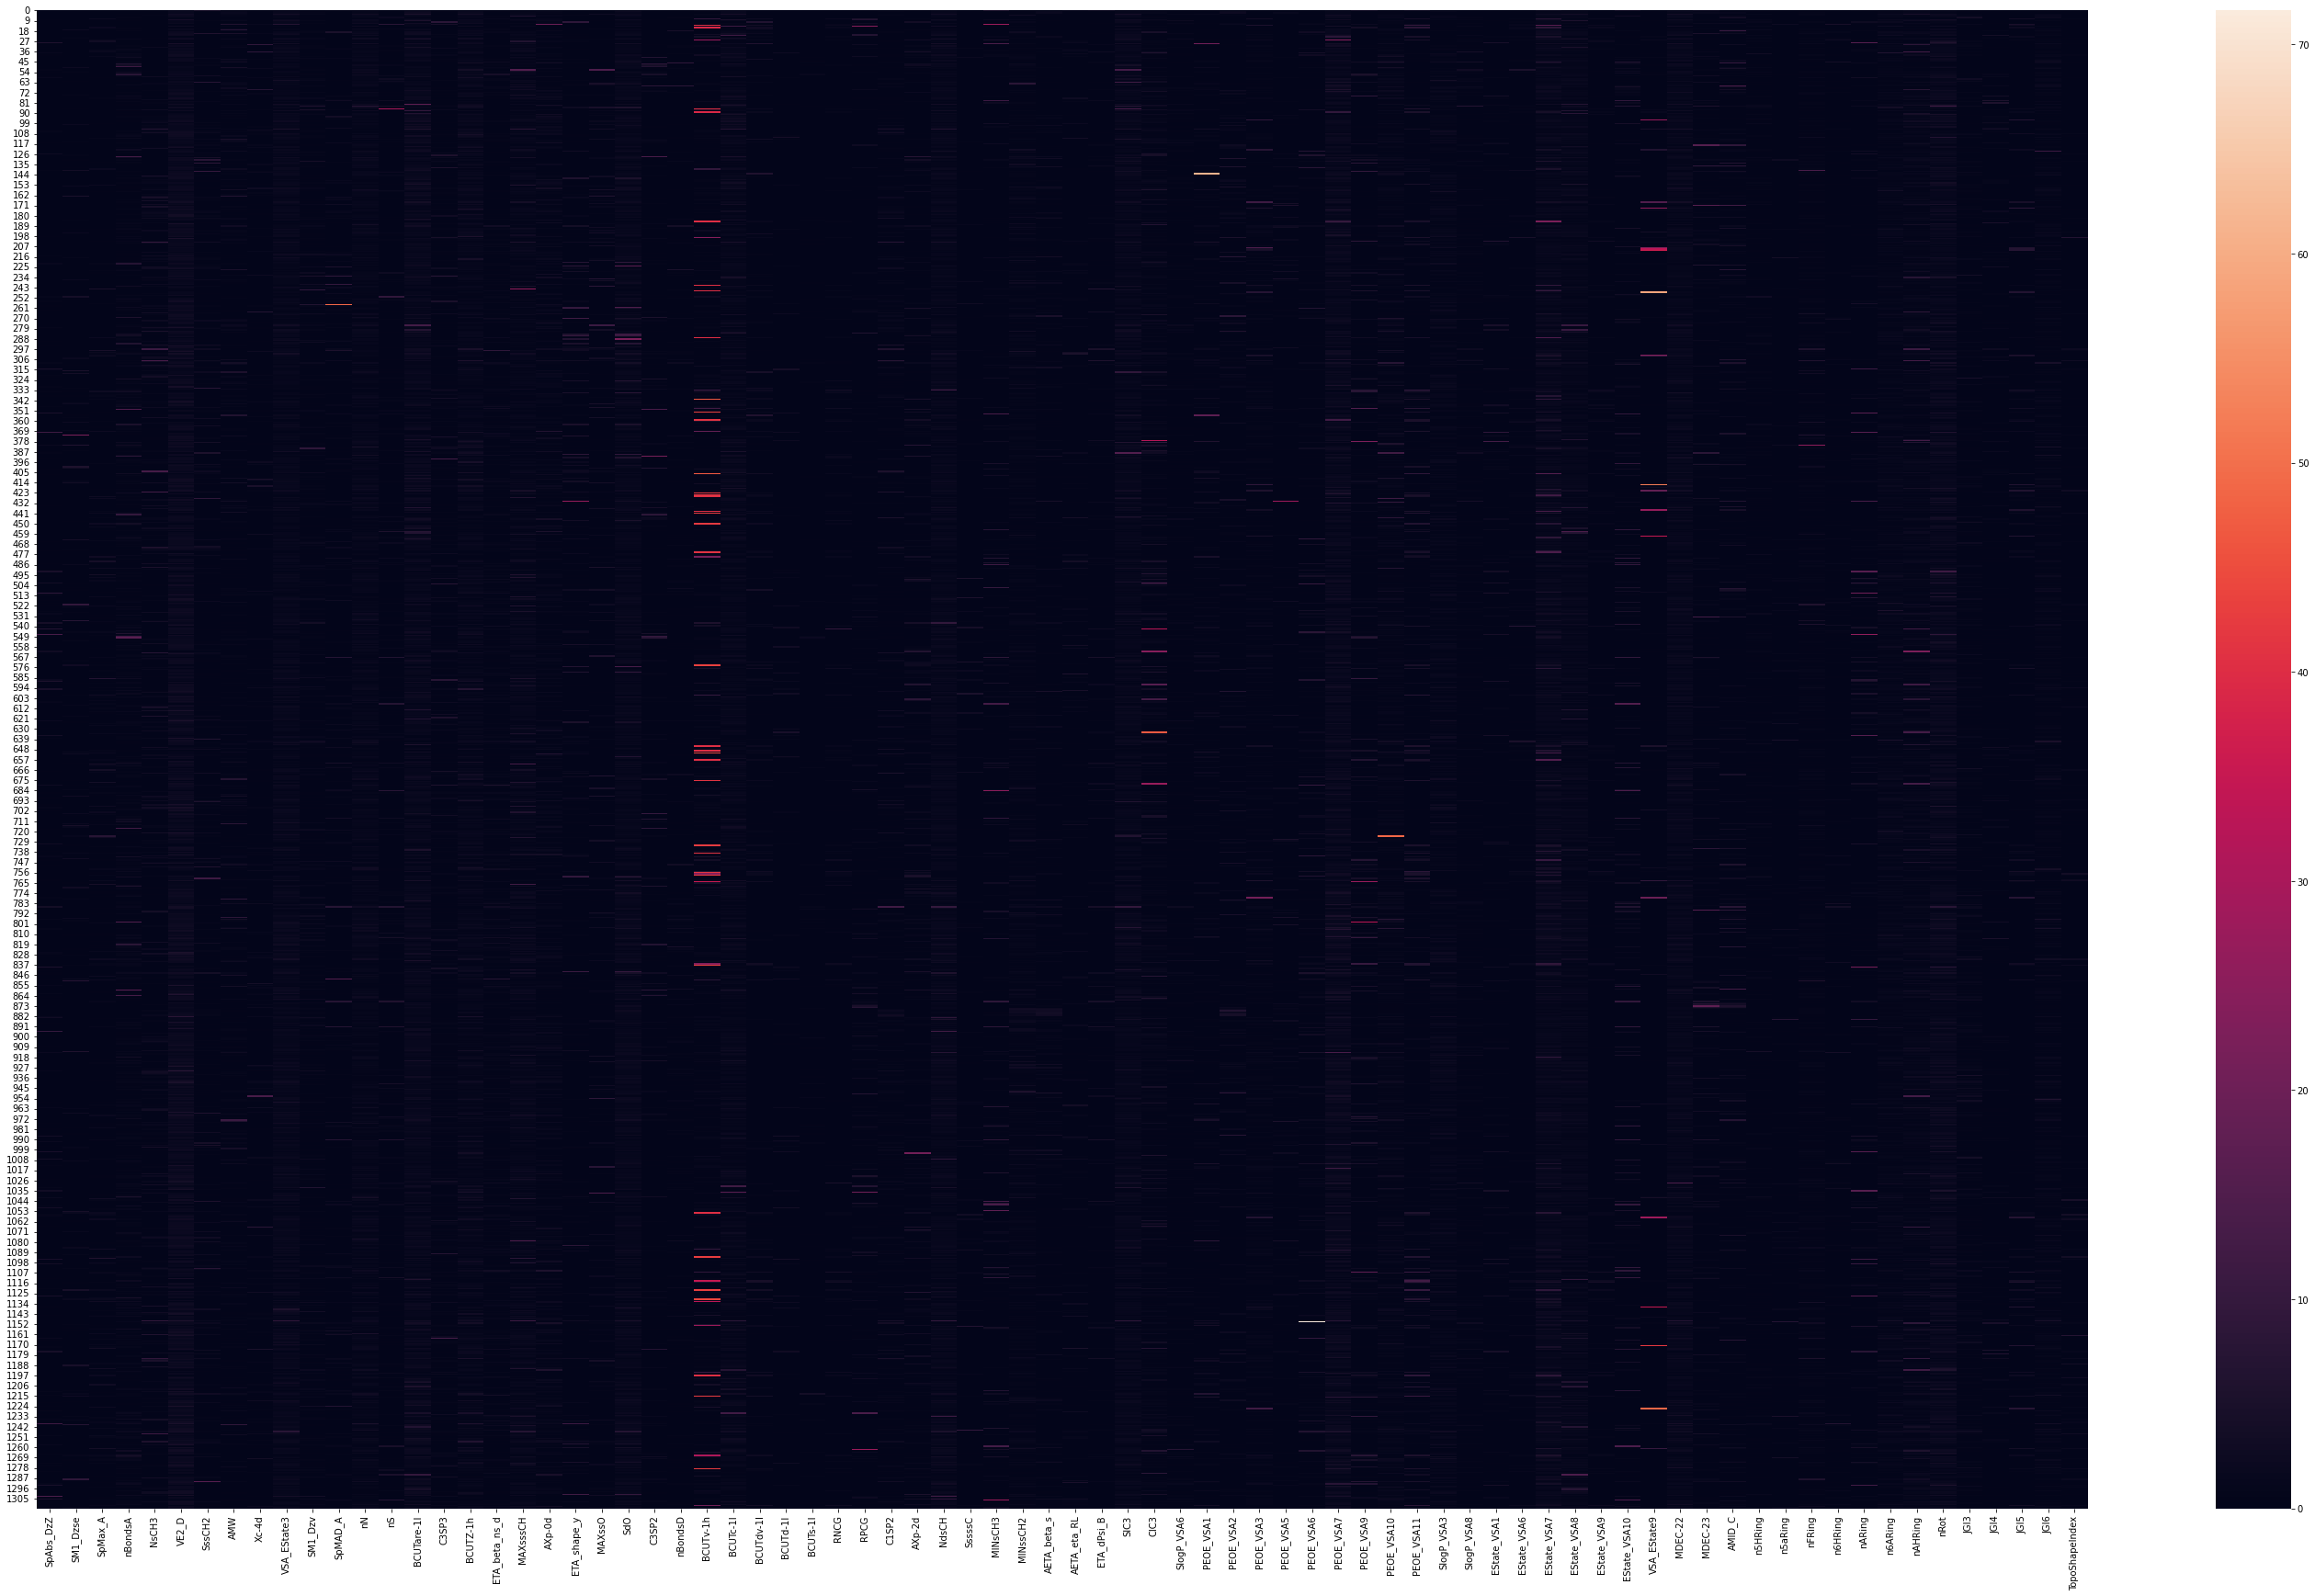

In [23]:
import seaborn as sns

explanation = clf.explain(X_test.values)

fig, ax = plt.subplots(figsize=(50,30))

sns.heatmap(data=explanation[0], xticklabels=X_test.columns, ax=ax)
plt.savefig('../images/FinalModels/tabnet_per_instance.png', dpi=300)

In [110]:
def get_mcs_mol_set(feature, indices):
    #Get the molecules with the highest importance for BCUTv-1h from explanation[0]
    #Get column indice of BCUTv-1h column
    column_index = X_test.columns.get_loc(feature)
    

    #Get the labels of these molecules from y_test
    labels = y_test.loc[indices]

    #Print percentage of molecules with each label
    print((labels.sum(axis=0)/len(labels) * 100).to_latex())

    #Get the smiles of these molecules from smiles_test
    smiles = smiles_test.loc[indices]

    #Find MCS of these molecules
    from rdkit.Chem import rdFMCS
    from rdkit.Chem import Draw
    from rdkit.Chem.Draw import SimilarityMaps
    from rdkit.Chem import AllChem
    import rdkit.Chem as Chem

    mols = [Chem.MolFromSmiles(smile) for smile in smiles]

    mcs = rdFMCS.FindMCS(mols)
    mcs_smarts = mcs.smartsString
    mcs_mol = Chem.MolFromSmarts(mcs_smarts)

    return mcs_mol

\begin{tabular}{lr}
\toprule
{} &           0 \\
\midrule
alcohol &    0.000000 \\
animal  &    0.000000 \\
aquatic &   11.111111 \\
earthy  &    0.000000 \\
flower  &    0.000000 \\
fruity  &   22.222222 \\
green   &   22.222222 \\
herbal  &   11.111111 \\
savory  &  100.000000 \\
spices  &    0.000000 \\
woody   &    0.000000 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


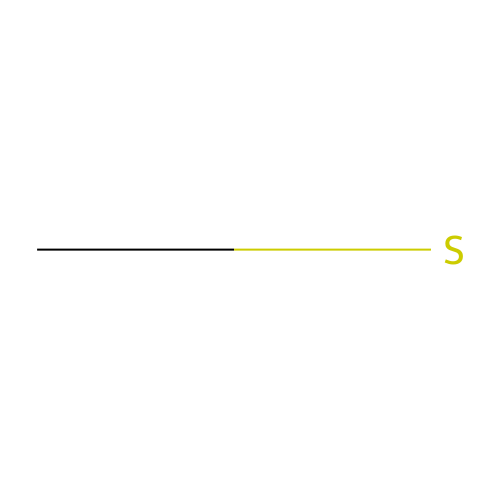

In [112]:
#Get mcs of molecules with nS higher than 2
indices = X_test.index[X_test["nS"] > 2]
mcs_mol = get_mcs_mol_set("nS", indices)

#Draw the MCS
Draw.MolToImage(mcs_mol, size=(500, 500))

\begin{tabular}{lr}
\toprule
{} &          0 \\
\midrule
alcohol &   0.000000 \\
animal  &   3.225806 \\
aquatic &   3.225806 \\
earthy  &   7.096774 \\
flower  &   3.225806 \\
fruity  &  28.387097 \\
green   &  21.290323 \\
herbal  &   9.677419 \\
savory  &  89.032258 \\
spices  &   0.000000 \\
woody   &   0.000000 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


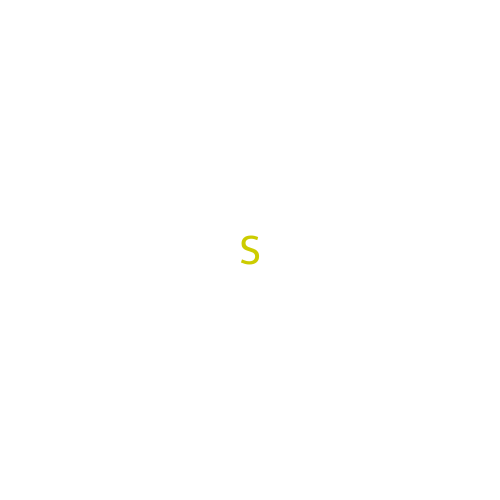

In [111]:
#Get mcs of molecules with BCUTv-1h value of >23
indices = X_test.index[X_test["BCUTv-1h"] > 23.0]
mcs_mol = get_mcs_mol_set("BCUTv-1h", indices)

#Draw the MCS
Draw.MolToImage(mcs_mol, size=(500, 500))

In [66]:
np.argsort(explanation[0][X_test.columns.get_loc("BCUTv-1h")])

array([ 0, 28, 30, 33, 35, 36, 39, 27, 40, 53, 56, 59, 60, 66, 75, 47, 23,
       38,  6,  1,  8, 15,  4, 11, 73, 31, 29, 48, 52, 19, 50, 25, 13, 17,
       77,  2, 32, 74, 61, 42, 69, 45, 37, 64, 44, 63, 46, 24, 55, 67, 20,
       54, 76, 65, 21, 51, 68, 10, 70, 71,  3,  7, 49, 18, 43, 26, 72, 57,
       22, 12,  9,  5, 62, 16, 41, 34, 58, 14], dtype=int64)

\begin{tabular}{lr}
\toprule
{} &     0 \\
\midrule
alcohol &  10.0 \\
animal  &  10.0 \\
aquatic &  20.0 \\
earthy  &   0.0 \\
flower  &  40.0 \\
fruity  &  40.0 \\
green   &  10.0 \\
herbal  &  20.0 \\
savory  &  50.0 \\
spices  &  10.0 \\
woody   &  10.0 \\
\bottomrule
\end{tabular}



In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.


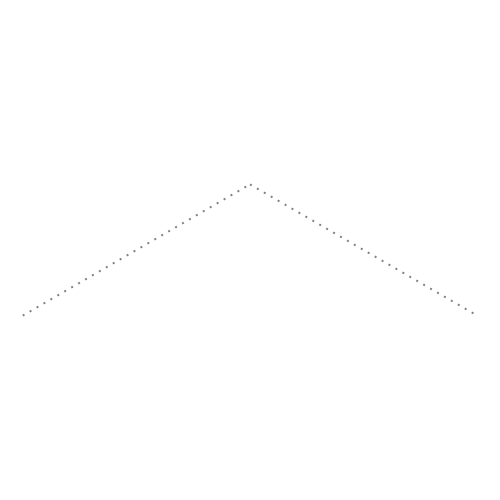

In [87]:
mcs = get_mcs_mol_set("BCUTv-1h", np.argsort(explanation[0][X_test.columns.get_loc("BCUTv-1h")])[::-1][:10])

#Draw the MCS
Draw.MolToImage(mcs, size=(500, 500))

<AxesSubplot:>

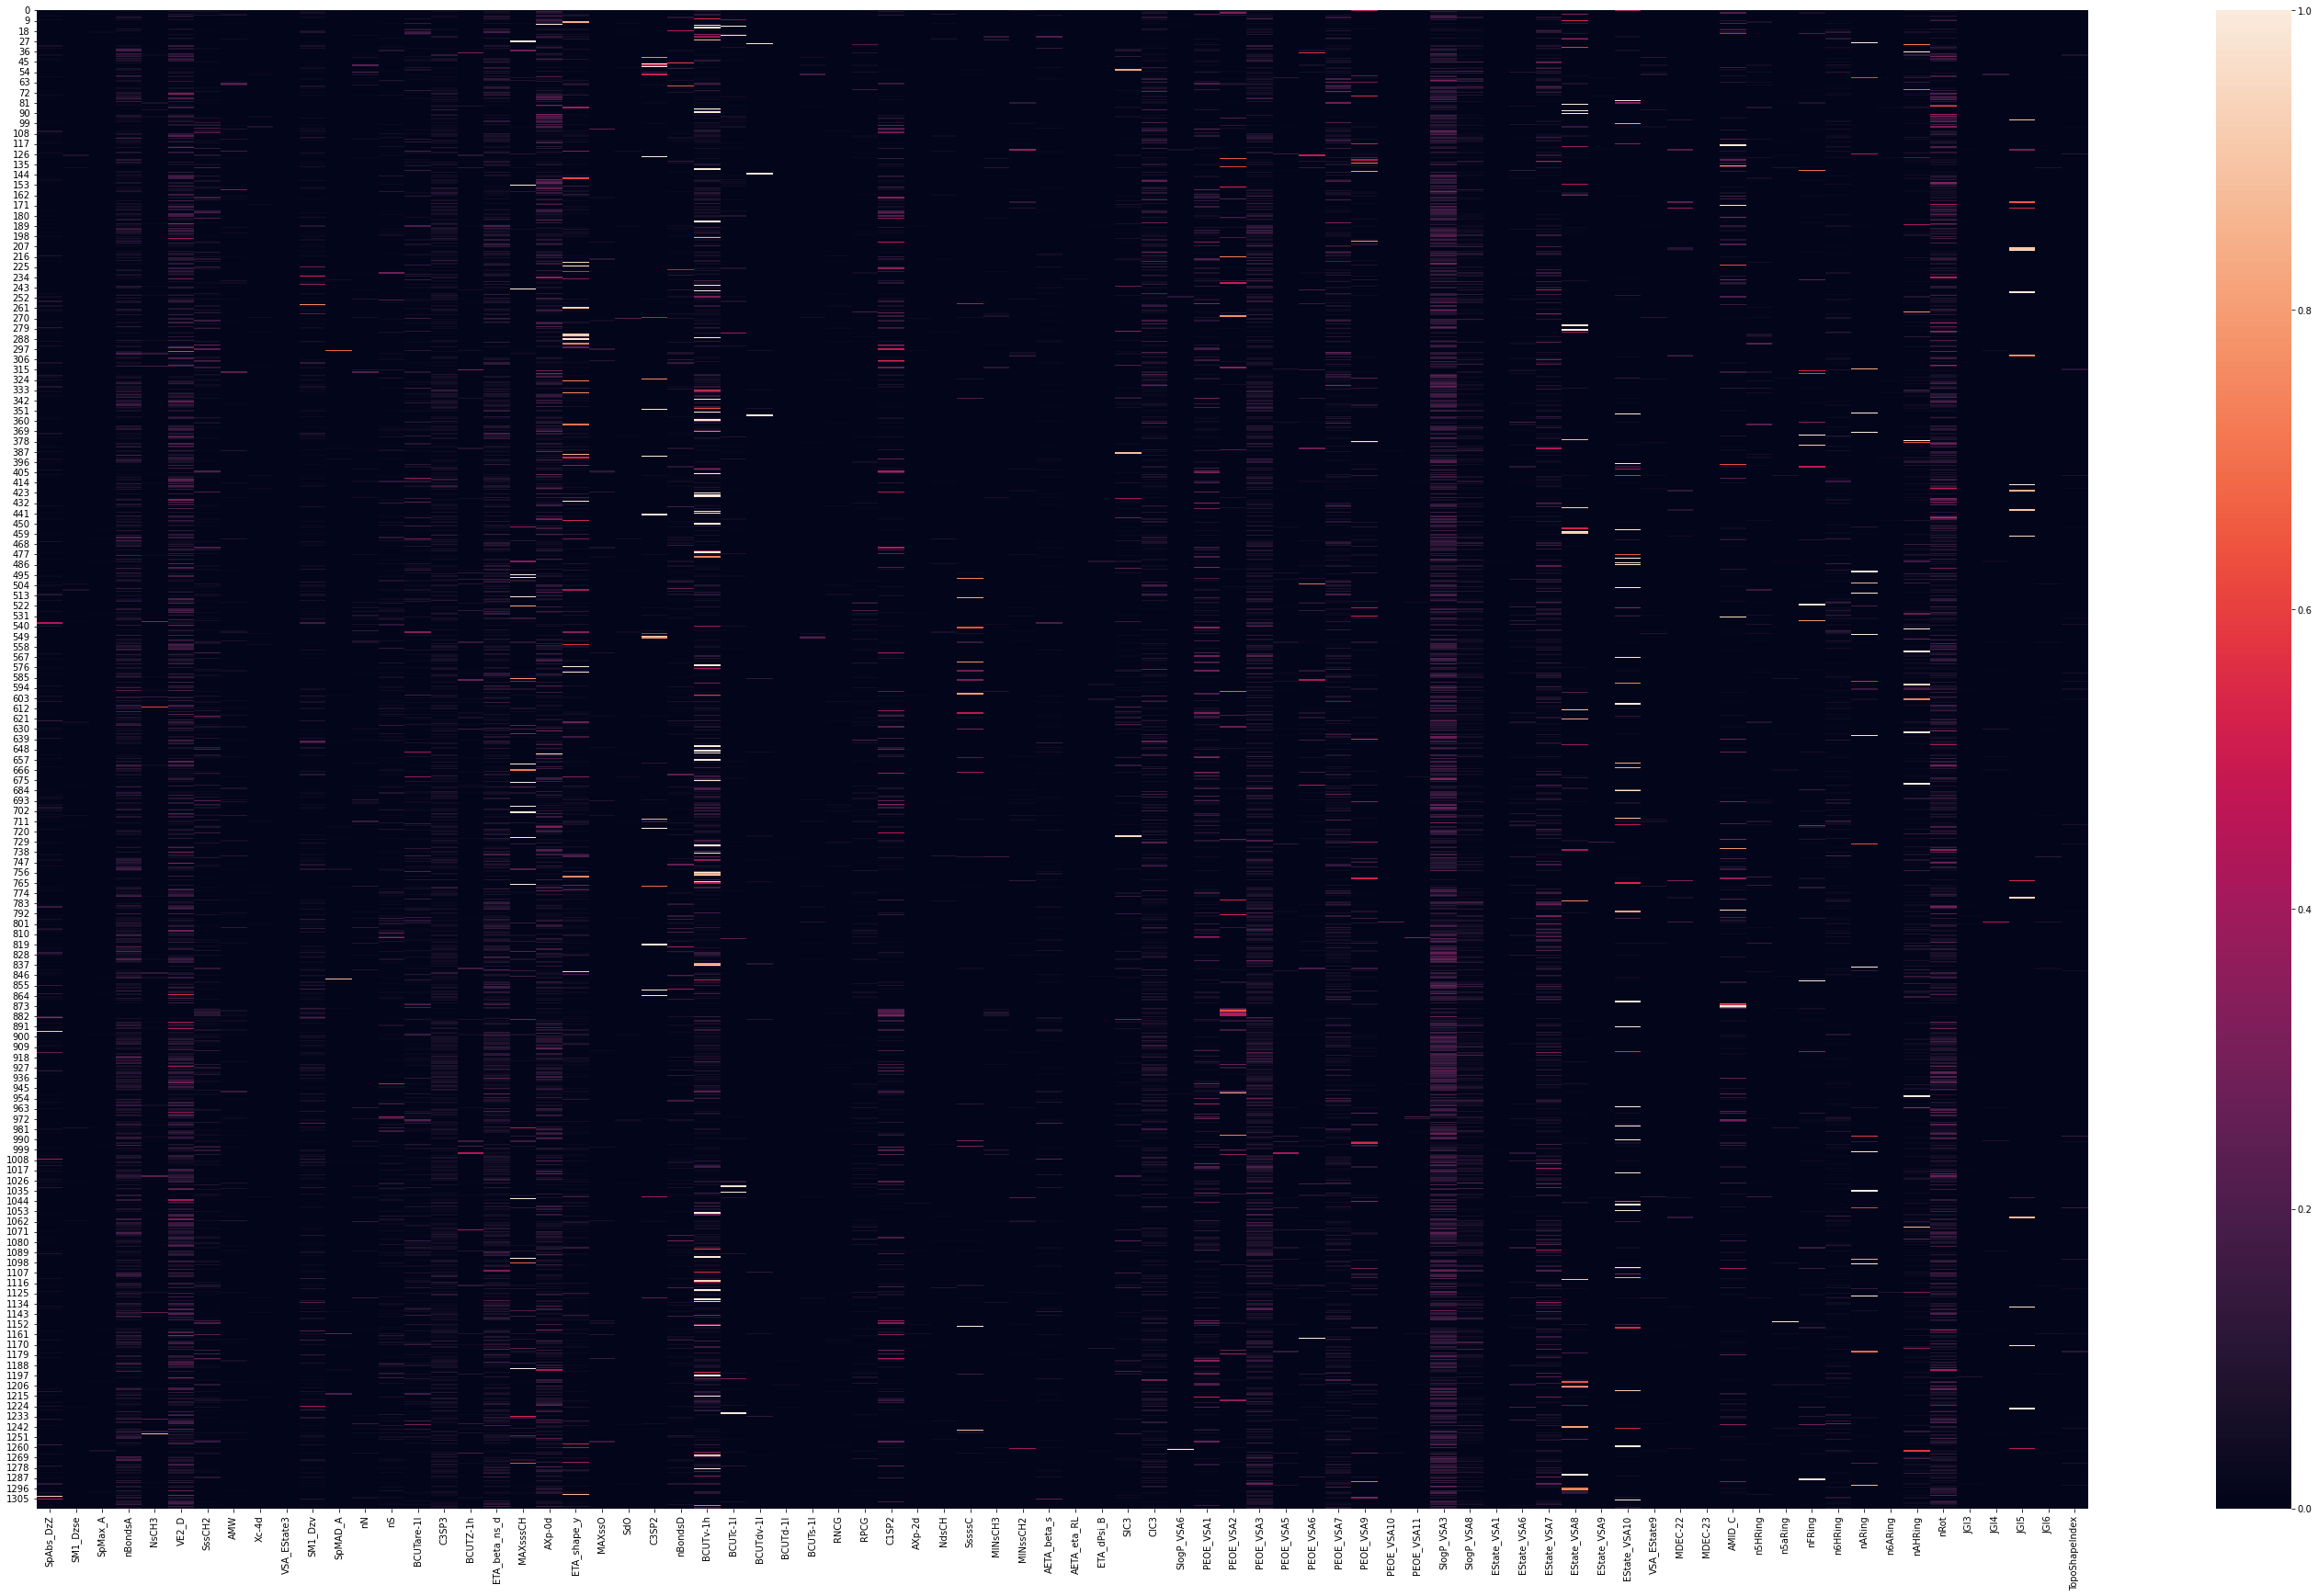

In [72]:
explanation[1][2].shape

fig, ax = plt.subplots(figsize=(50,30))

sns.heatmap(data=explanation[1][1], xticklabels=X_test.columns, ax=ax)

alcohol     7.5
animal     15.0
aquatic    17.5
earthy      7.5
flower     30.0
fruity     47.5
green      25.0
herbal     37.5
savory     47.5
spices      5.0
woody       7.5
dtype: float64


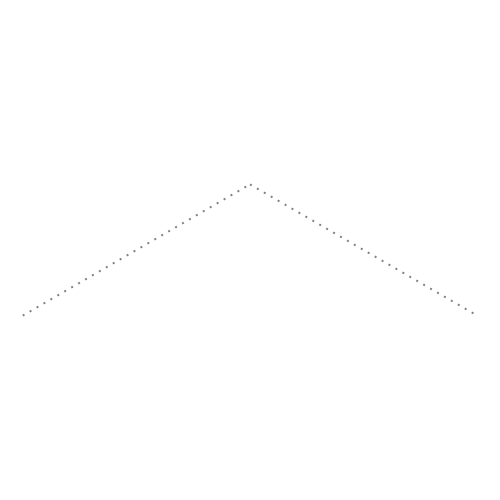

In [70]:
mcs2 = get_mcs_mol_set("PEOE_VSA11", np.argsort(explanation[1][2][X_test.columns.get_loc("PEOE_VSA11")])[::-1][:40])

#Draw the MCS
Draw.MolToImage(mcs2, size=(500, 500))

In [ ]:
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_tree, to_graphviz

graph = to_graphviz(xgboost, num_trees=0)
graph.format = 'png'
graph.render('xgboost_tree', view=True)

'xgboost_tree.png'

In [ ]:
# from sklearn.model_selection import train_test_split
# from xgboost import XGBClassifier
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
# import matplotlib.pyplot as plt
# import seaborn as sns

# fig, axes = plt.subplots(6, 2, figsize=(20, 30))  # Adjust the number of rows and columns as needed
# axes = axes.flatten()

# #Set title and axis labels
# fig.suptitle("Feature Importance of XGBoost classifier classifying whether or not a compound will be predicted correctly for each class", fontsize=16)

# for i in range(len(axes)-1):
#     X_correct = X_test
#     y_correct = y_test[y_test.columns[i]]

#     X_correct_0 = X_correct.loc[y_correct == 0]
#     X_correct_1 = X_correct.loc[y_correct == 1]

#     X_correct_0 = X_correct_0.sample(n=len(X_correct_1), random_state=0)

#     X_correct = pd.concat([X_correct_0, X_correct_1])
#     y_correct = y_correct.loc[X_correct.index]

#     X_train_correct, X_test_correct, y_train_correct, y_test_correct = train_test_split(X_correct, y_correct, test_size=0.2, random_state=0)

#     clf = XGBClassifier(random_state=0)
#     clf.fit(X_train_correct, y_train_correct)

#     y_hat = clf.predict(X_test_correct)

#     print("=====================================")
#     print("Class: ", y_test.columns[i])

#     print("Accuracy: ", accuracy_score(y_test_correct, y_hat))
#     print("Precision: ", precision_score(y_test_correct, y_hat))
#     print("Recall: ", recall_score(y_test_correct, y_hat))
#     print("F1: ", f1_score(y_test_correct, y_hat))
#     print("AUROC: ", roc_auc_score(y_test_correct, y_hat))

#     importance = pd.DataFrame(clf.feature_importances_, columns=["Importance"], index=X_train_correct.columns).sort_values(by="Importance", ascending=False)
#     most_important = importance.iloc[0, :]
    
#     #Get index of TP, FP, TN, FN from y_test and y_hat_clf for this class
#     #Use these to plot the KDE plots
#     y_test_1 = y_test.index[y_test[y_test.columns[i]] == 1]
#     y_test_0 = y_test.index[y_test[y_test.columns[i]] == 0]
#     y_hat_clf_1 = y_hat_clf.index[y_hat_clf[y_hat_clf.columns[i]] == 1]
#     y_hat_clf_0 = y_hat_clf.index[y_hat_clf[y_hat_clf.columns[i]] == 0]

#     TP = X_test.loc[y_test_1.intersection(y_hat_clf_1)][most_important.name]
#     FP = X_test.loc[y_test_0.intersection(y_hat_clf_1)][most_important.name]
#     TN = X_test.loc[y_test_0.intersection(y_hat_clf_0)][most_important.name]
#     FN = X_test.loc[y_test_1.intersection(y_hat_clf_0)][most_important.name]
    
#     sns.kdeplot(data=TP, ax=axes[i], label="TP")
#     sns.kdeplot(data=FP, ax=axes[i], label="FP")
#     sns.kdeplot(data=TN, ax=axes[i], label="TN")
#     sns.kdeplot(data=FN, ax=axes[i], label="FN")
#     axes[i].set_title("Class: " + y_test.columns[i] + ", Feature: " + most_important.name + ", Importance: " + str(most_important.values[0]) + ", AUROC: " + str(results_per_class.loc[y_test.columns[i], "AUROC"]))
#     axes[i].set_xlabel("Feature Value")
#     axes[i].set_ylabel("Density")
#     axes[i].legend()
    
# fig.tight_layout()
# fig.subplots_adjust(top=0.9)
# plt.show()